# **📚 Overall Project Proposal**
## Data Integrity in Action: Pre-processing Young People’s Records for Smarter Insights

From Data Chaos to Data-Driven Insights- This portfolio will present three interconnected projects that together form a phased, progressive, integrated, end-to-end data pipeline: (1) establishing a reliable data foundation, (2) enabling visual storytelling for stakeholders, and (3) piloting predictive/prescriptive approaches to personalise future programming.

Across all phases, the portfolio will demonstrate a full pipeline from raw data to actionable insights as well as my ability to handle real-world data challenges, build effective analytics workflows, and translate insights into meaningful organisational value.

## 🎨 Setup

## Load cleaned datasets from Project 1

Project 2 expects the cleaned/enriched data created in Project 1. If you have already run Project 1 (and the export cell at the end), this will load the saved files from the `outputs/` folder.

In [ ]:
from pathlib import Path
import pickle

out_dir = Path("outputs")

def load_pickle(name):
    path = out_dir / f"{name}.pkl"
    if not path.exists():
        raise FileNotFoundError(
            f"Missing {path}.\n\nRun Project 1 first, then run the export cell at the end of Project 1 to generate the outputs/ files."
        )
    with open(path, "rb") as f:
        return pickle.load(f)

# Required for this notebook
Att_v3 = load_pickle("Att_v3")
Att_v4 = load_pickle("Att_v4")

# Optional (loads if present)
try:
    Att_v4_pivot_region = load_pickle("Att_v4_pivot_region")
except FileNotFoundError:
    Att_v4_pivot_region = None

try:
    Fb_new = load_pickle("Fb_new")
except FileNotFoundError:
    Fb_new = None

print("Loaded:", "Att_v3", Att_v3.shape, "|", "Att_v4", Att_v4.shape)


In [1]:
#Set up the environment
import pandas as pd #Load the dataset from data/SSphere.csv into a DataFrame- used to "tidy" up and manipulate our data

import numpy as np #To use later for stats analysis- used for matrix and numerical calculations; foundation of pandas

import itertools

from scipy import stats #contains stats functions and is used to visualise probability distributions

import matplotlib.pyplot as plt #used for visualisations
%matplotlib inline

import matplotlib as mpl
from matplotlib import font_manager
from matplotlib.axes._axes import _log as matplotlib_axes_logger # Suppress Matplotlib specific warnings except errors
matplotlib_axes_logger.setLevel('ERROR')
import warnings
warnings.filterwarnings('ignore') # Suppressing all other general warnings except errors

import seaborn as sns #more user-friendly library used for visualisations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# time-series (optional)
from statsmodels.tsa.holtwinters import ExponentialSmoothing

**Note:** This notebook assumes you have already generated the cleaned/enriched datasets from **Project 1** (e.g., `Att_v3`, `Att_v4`, `Fb_new`) or have loaded equivalent exports from your processed data. If you run this notebook standalone, add a data-loading cell here to read in the Project 1 output CSV(s).

# **2️⃣ Project 2:**
## Insight in Focus: Communicating Attendance & Impact with Monthly Visual Analytics Dashboards

Project 2 builds on this foundation by creating clear and compelling visualisations that communicate monthly patterns in attendance, demographics, and impact outcomes. Through reusable dashboards and visual analytics, this phase ensures that staff, funders, and other stakeholders can quickly understand who Stemettes is reaching, how participants engage over time, and which interventions deliver the strongest results. The goal is to strengthen data fluency across teams and enable insight-driven decision-making to support programming and funding applications.

## 🎨 Specs for End-Users

understanding of my audience

In [66]:
#Define brand palette (for general use)
brand_colours = [
    "#0a3dd9",  # Cobalt Blue
    "#007fff",  # Azure Blue
    "#f0c808",  # AU Yellow
    "#ea9010",  # Orange
    "#61e294",  # Python Green
    "#8377d1",  # HTML Purple
]

#Set the custom brand colours/fonts as default theme
def set_brand_style(brand_colours):
    # Register fonts
    font_manager.fontManager.addfont("Fonts/LeagueSpartan-Regular.ttf")
    font_manager.fontManager.addfont("Fonts/LexendDeca-Regular.ttf")
    font_manager.fontManager.addfont("Fonts/LeagueSpartan-Bold.ttf")
    
    # Get internal font family names
    spartan_font = font_manager.FontProperties(fname="Fonts/LeagueSpartan-Regular.ttf").get_name()
    lexend_font = font_manager.FontProperties(fname="Fonts/LexendDeca-Regular.ttf").get_name()
    bold_spartan = font_manager.FontProperties(fname="Fonts/LeagueSpartan-Bold.ttf").get_name()
    
    # Set global font and visual style
    mpl.rcParams['font.family'] = lexend_font
    mpl.rcParams['axes.titleweight'] = 'bold'
    mpl.rcParams['axes.titlesize'] = 14

    # Set brand colours and styles
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=brand_colours[:3])
    mpl.rcParams['axes.facecolor'] = "#ffffff"
    mpl.rcParams['figure.facecolor'] = "#ffffff"
    mpl.rcParams['grid.color'] = "#dddddd"
    mpl.rcParams['axes.edgecolor'] = "#0a3dd9"
    mpl.rcParams['axes.labelcolor'] = "#0a3dd9"
    mpl.rcParams['xtick.color'] = "#0a3dd9"
    mpl.rcParams['ytick.color'] = "#0a3dd9"

    return {"headers": bold_spartan, "body": lexend_font}

#Apply font and styling
fonts = set_brand_style(brand_colours)

#Apply theme globally
sns.set_theme(
    style="whitegrid",
    palette=brand_colours,
    font=fonts["body"]
)

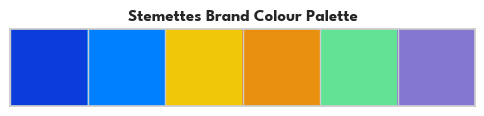

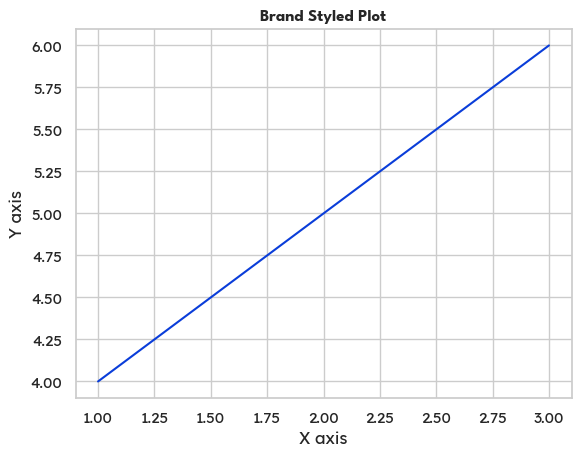

In [67]:
#Plot brand palette preview
sns.palplot(sns.color_palette(brand_colours))
plt.title("Stemettes Brand Colour Palette", fontname=fonts['headers'], fontweight='bold')
plt.show()

#Example usage for a plot title using Spartan font:
plt.plot([1, 2, 3], [4, 5, 6])
plt.title("Brand Styled Plot", fontname=fonts["headers"])  # Spartan font for title
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.show()

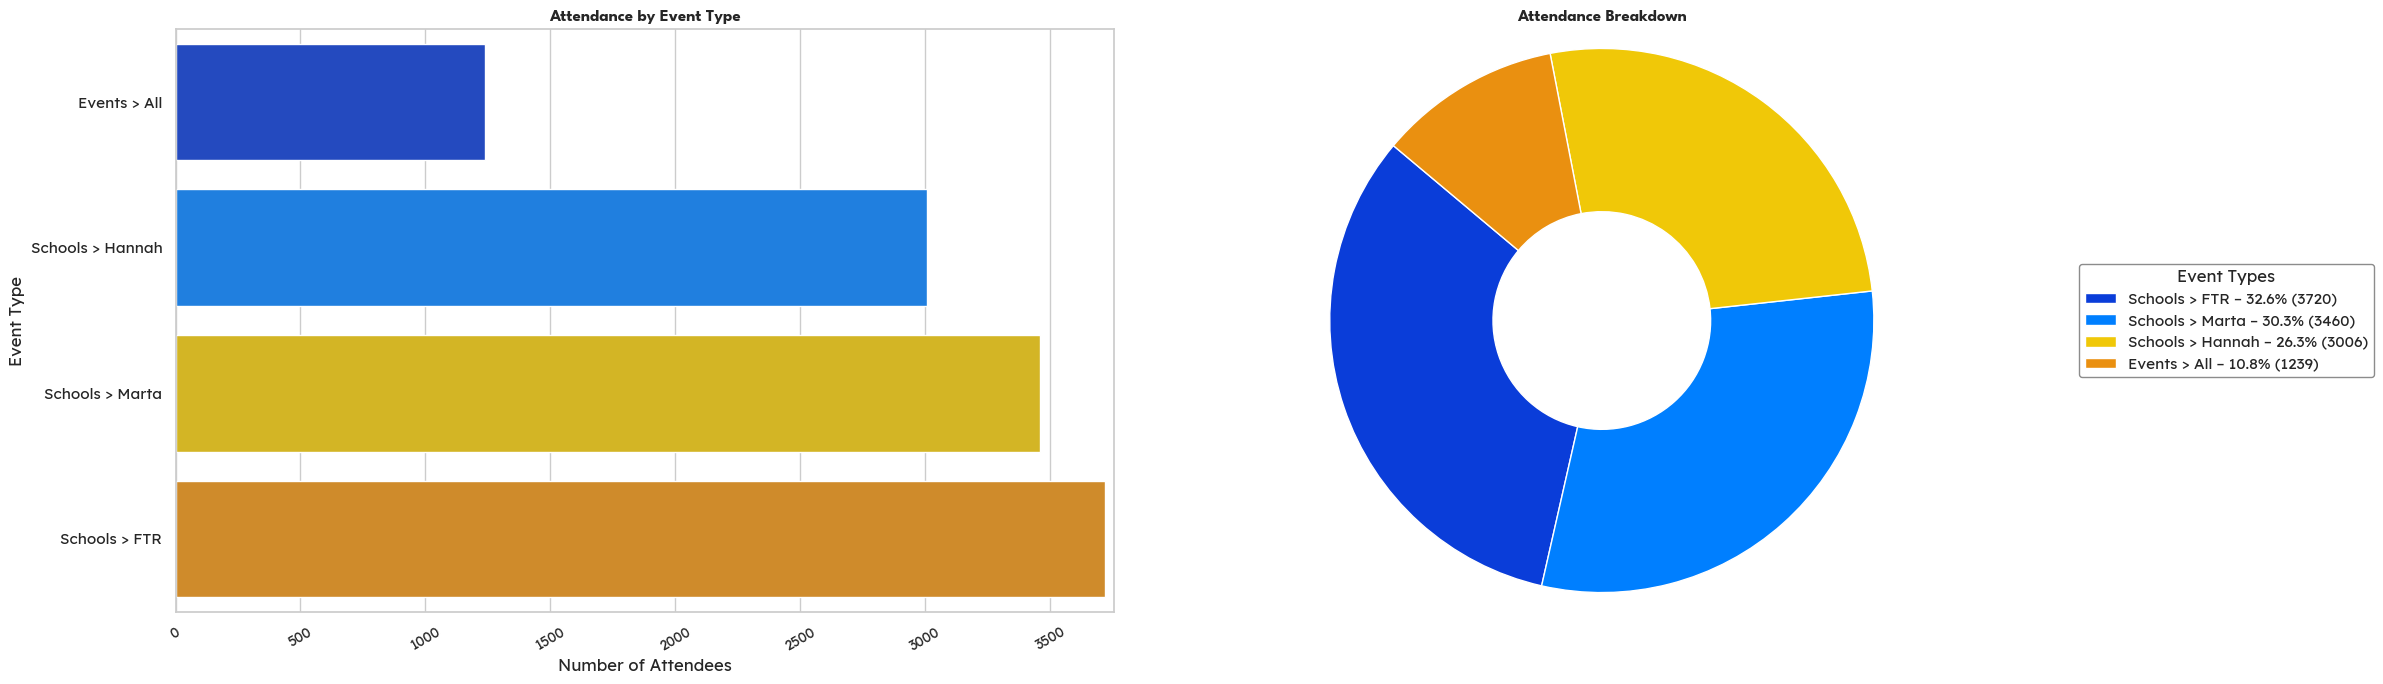

In [68]:
from itertools import cycle, islice

# Count and percentage data
event_counts = Att_v3['Type'].value_counts()
event_percentages = event_counts / event_counts.sum() * 100
labels = event_counts.index
counts = event_counts.values
percentages = event_percentages.values

# Colour palette
num_types = len(labels)
colors = list(islice(cycle(brand_colours), num_types))

# Custom legend entries
legend_labels = [
    f"{label} – {perc:.1f}% ({count})"
    for label, perc, count in zip(labels, percentages, counts)
]

# Create longer figure for more space
fig, axes = plt.subplots(1, 2, figsize=(24, 7))  # Wider for label spacing

# --- BAR CHART ---
sns.countplot(
    data=Att_v3,
    y='Type',
    order=labels[::-1],  # optional: reverse for top-down order
    palette=colors,
    ax=axes[0]
)
axes[0].set_title('Attendance by Event Type', fontname=fonts['headers'])
axes[0].set_xlabel('Number of Attendees')
axes[0].set_ylabel('Event Type')
axes[0].tick_params(axis='x', rotation=30)  # less severe angle

# Optional: adjust spacing under x labels
axes[0].tick_params(axis='x', labelsize=10)
axes[0].margins(x=0.01)

# --- DONUT CHART ---
sizes = percentages
wedges, _ = axes[1].pie(
    sizes,
    labels=None,
    startangle=140,
    colors=colors,
    wedgeprops=dict(width=0.6)
)

centre_circle = plt.Circle((0, 0), 0.35, fc='white')
axes[1].add_artist(centre_circle)

axes[1].legend(
    wedges,
    legend_labels,
    title='Event Types',
    title_fontproperties={'weight': 'bold'},
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=True,
    fancybox=True,
    edgecolor='grey',
    framealpha=0.9
)

axes[1].set_title('Attendance Breakdown', fontname=fonts['headers'])
axes[1].axis('equal')

plt.tight_layout()
plt.show()

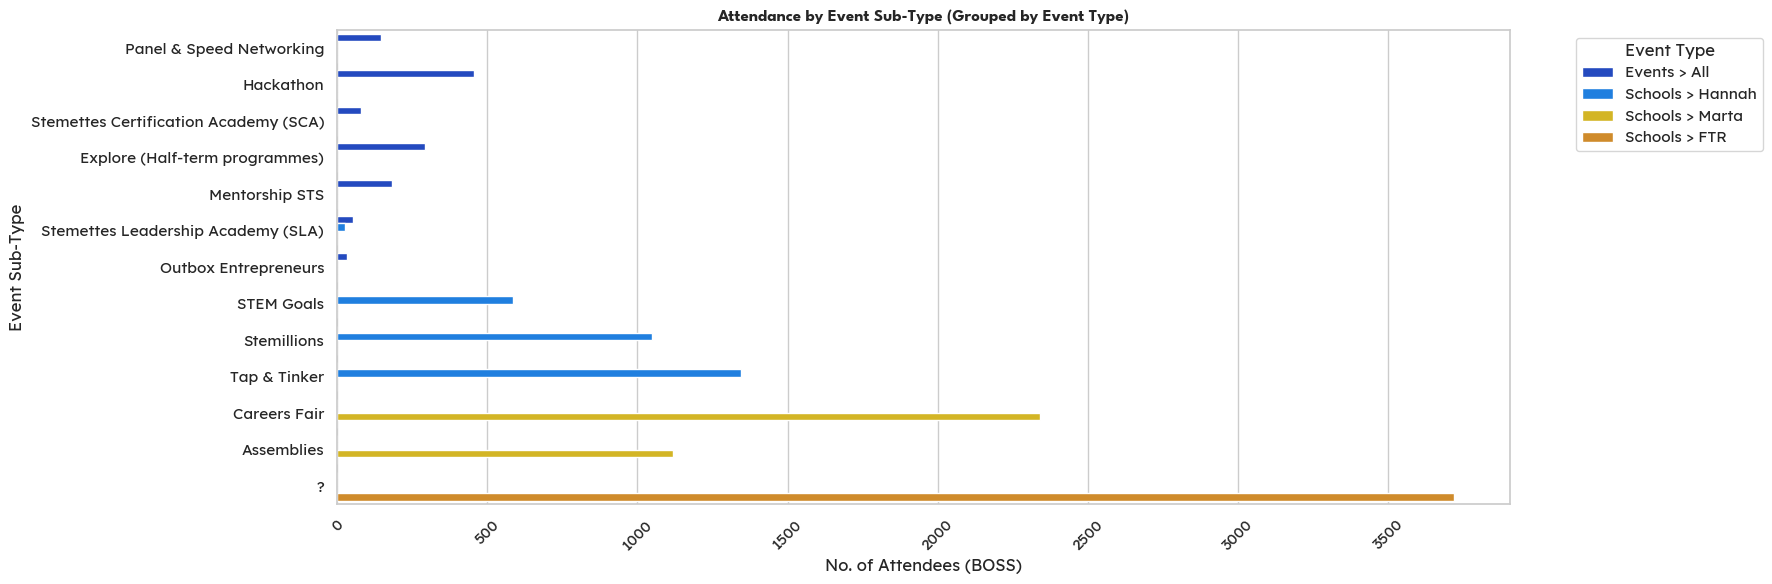

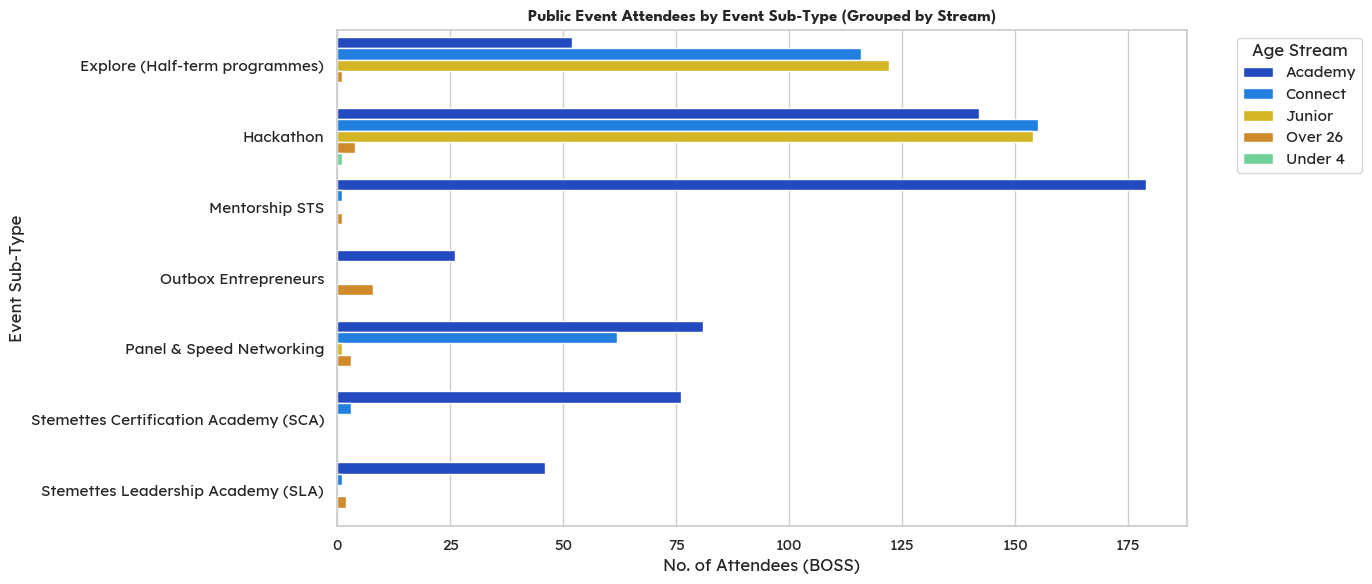

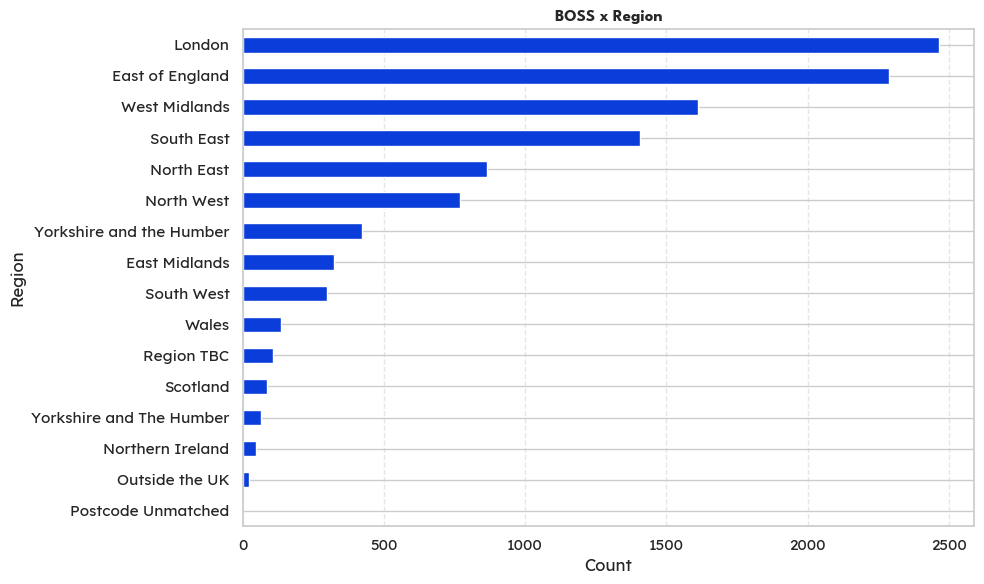

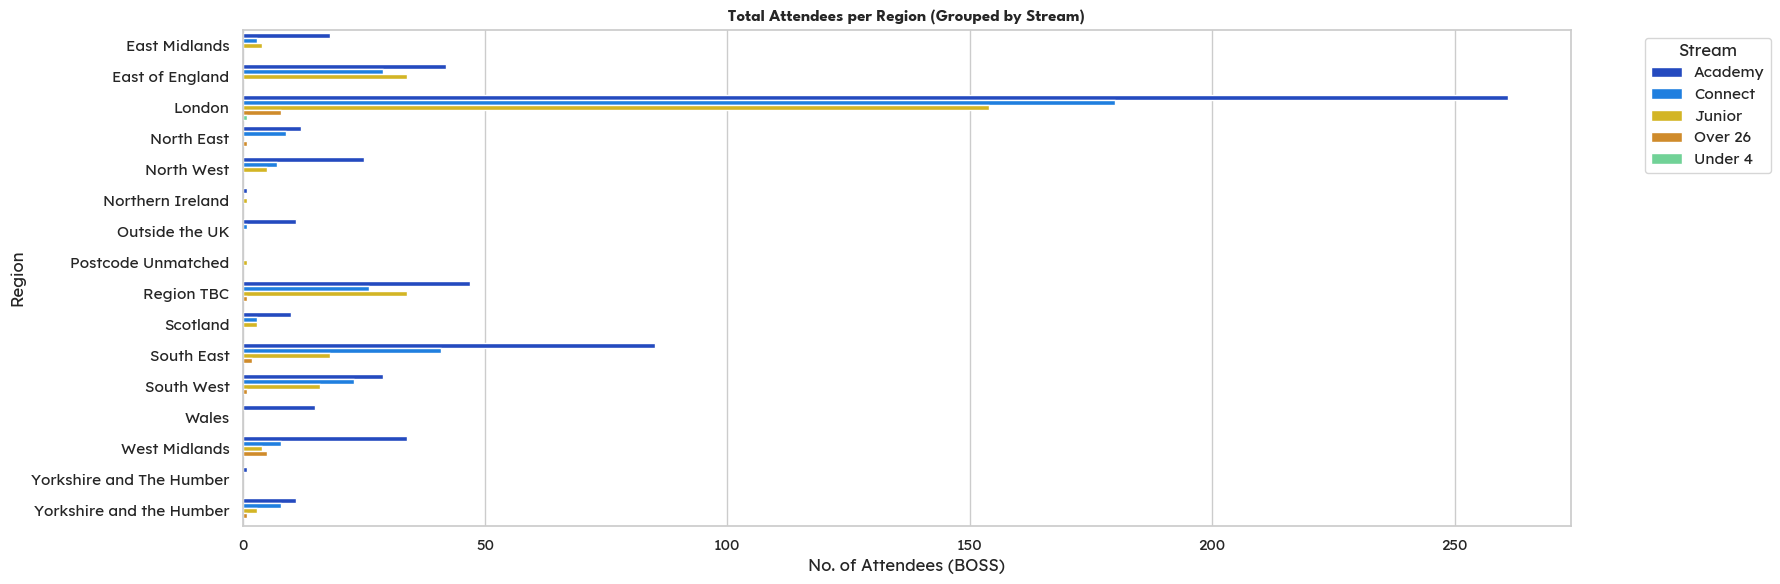

In [69]:
#Plotting Attendance counts by Event Type now that School Event data has been added
plt.figure(figsize=(18, 6))

sns.countplot(
    data=Att_v3,
    y='Event Sub-Type',  #Group by Type
    hue='Type',  #Split by Sub-Type
    palette=brand_colours) #Wanted to do shade_mapping- but hackathon error

plt.xticks(rotation=45)
plt.title('Attendance by Event Sub-Type (Grouped by Event Type)', fontname=fonts['headers'])
plt.xlabel('No. of Attendees (BOSS)')
plt.ylabel('Event Sub-Type')
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

group1 = t1.groupby(['Type', 'Event Sub-Type', 'Stream'])['Quantity'].sum().reset_index()

# Plotting Total Attendees per "Stream" for each "Event Sub-Type" (Grouped by "Type")
plt.figure(figsize=(14, 6))
sns.barplot(data=group1, y='Event Sub-Type', x='Quantity', hue='Stream', palette=brand_colours)
plt.title('Public Event Attendees by Event Sub-Type (Grouped by Stream)', fontname=fonts['headers'])
plt.xlabel('No. of Attendees (BOSS)')
plt.ylabel('Event Sub-Type')
plt.legend(title='Age Stream', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
#should be Att_v3 not Att_v4 or t1

#Count how many attendeees per Region (or any categorical column)
event_sub_type_counts = Att_v3['Region'].value_counts().sort_values(ascending=True) #Region = Region

# Plot it
plt.figure(figsize=(10, 6))
event_sub_type_counts.plot(kind='barh')

plt.title("BOSS x Region", fontname=fonts["headers"])
plt.xlabel("Count", fontname=fonts["body"])
plt.ylabel("Region", fontname=fonts["body"])

plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Create a crosstab for adjacent (grouped) bars
group5 = t1.groupby(['Type', 'Region', 'Stream'])['Quantity'].sum().reset_index()

# Plotting Total Attendees per "Stream" for each "Region" (Grouped by "Stream")
plt.figure(figsize=(18, 6))
sns.barplot(data=group5, y='Region', x='Quantity', hue='Stream', palette=brand_colours)
plt.title('Total Attendees per Region (Grouped by Stream)', fontname=fonts['headers'])
plt.xlabel('No. of Attendees (BOSS)')
plt.ylabel('Region')
plt.legend(title='Stream', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

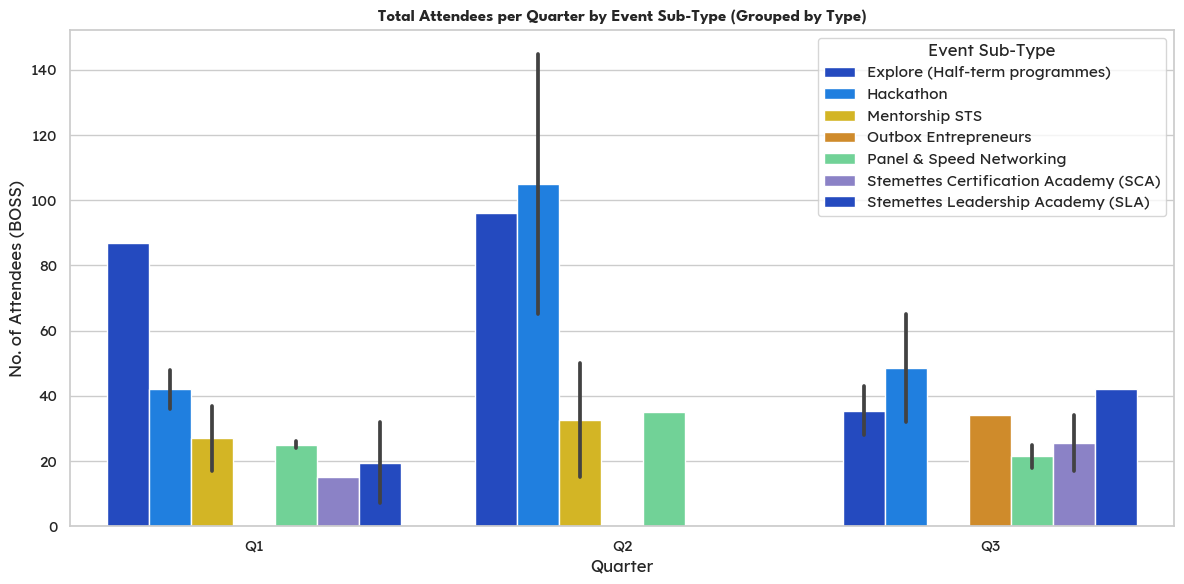

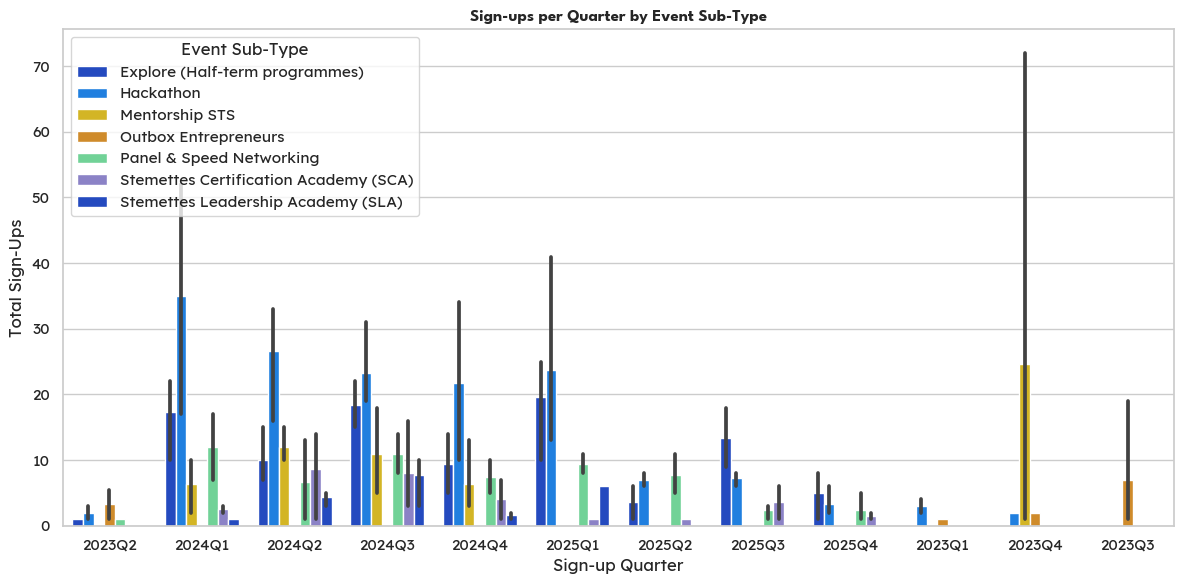

In [70]:
# Total Attendees per Month and Quarter (from "Year-Quarter-Month") for each "Event Sub-Type" (Grouped by "Type") - Assuming format: 'YYYY - QX - [M] MonthName'
t1[['Year', 'Quarter', 'Month']] = t1['Year-Quarter-Month'].str.extract(r'(\d{4})\s*-\s*(Q\d)\s*-\s*\[\d\]\s*(\w+)')

group2 = t1.groupby(['Type', 'Event Sub-Type', 'Quarter', 'Month'])['Quantity'].sum().reset_index()

# Plot example: per Quarter
plt.figure(figsize=(12, 6))
sns.barplot(data=group2, x='Quarter', y='Quantity', hue='Event Sub-Type', palette=brand_colours)
plt.title('Total Attendees per Quarter by Event Sub-Type (Grouped by Type)', fontname=fonts['headers'])
plt.ylabel('No. of Attendees (BOSS)')
plt.tight_layout()
plt.show()

#Total Attendees per Month and Quarter (from "Sign-up Date/Time") for each "Event Sub-Type" (Grouped by "Type")
t1['Sign-up Date/Time'] = pd.to_datetime(t1['Sign-up Date/Time'], errors='coerce')
t1['Sign-up Month'] = t1['Sign-up Date/Time'].dt.month_name()
t1['Sign-up Quarter'] = t1['Sign-up Date/Time'].dt.to_period('Q').astype(str)

group3 = t1.groupby(['Type', 'Event Sub-Type', 'Sign-up Quarter', 'Sign-up Month'])['Quantity'].sum().reset_index()

# Plot example
plt.figure(figsize=(12, 6))
sns.barplot(data=group3, x='Sign-up Quarter', y='Quantity', hue='Event Sub-Type', palette=brand_colours)
plt.title('Sign-ups per Quarter by Event Sub-Type', fontname=fonts['headers'])
plt.ylabel('Total Sign-Ups')
plt.tight_layout()
plt.show()

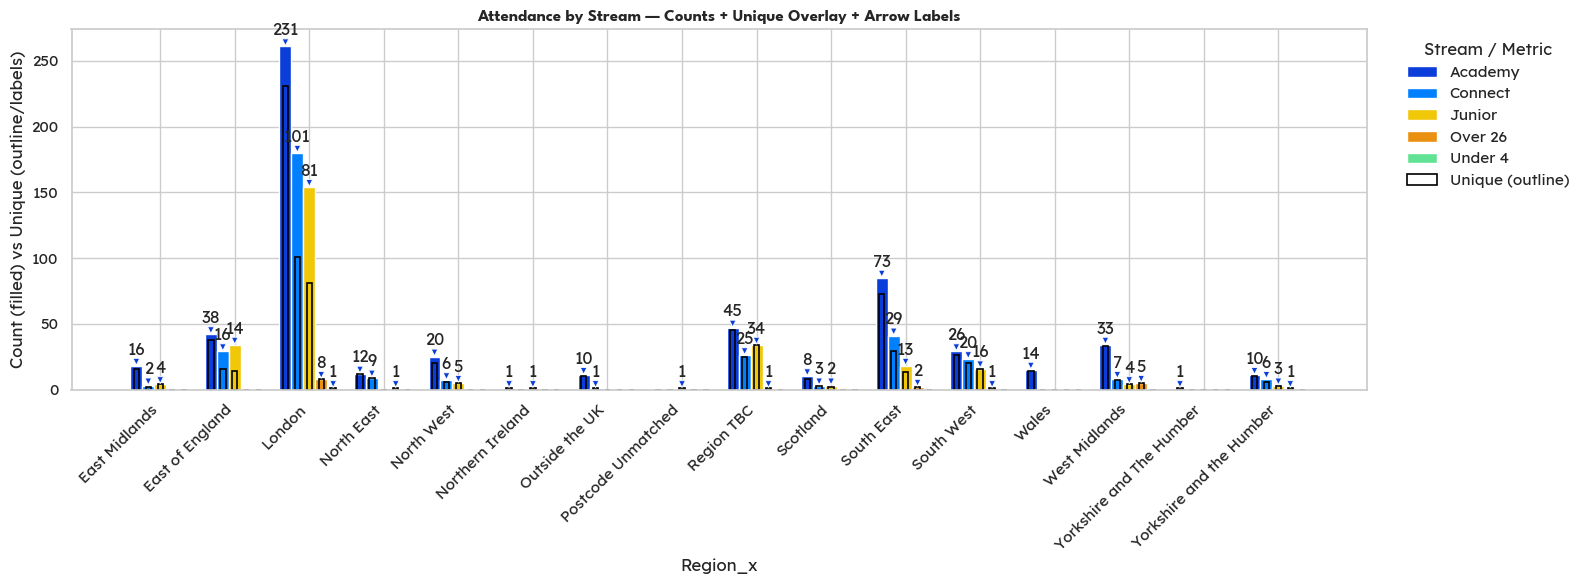

In [71]:
# Counts (filled) + Unique (thin outline overlay) + Unique (arrow labels), WITHOUT totals
import numpy as np, itertools
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Optional fallbacks (only used if you haven't defined these already)
try:
    brand_colours
except NameError:
    brand_colours = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['#4e79a7','#f28e2b','#e15759','#76b7b2','#59a14f','#edc948','#b07aa1','#ff9da7','#9c755f','#bab0ab'])
try:
    header_font = fonts["headers"]
except Exception:
    header_font = None  # fall back to default

# --- Start from Region x Stream pivot (already flattened) ---
pivot_df = Att_v4_pivot_region.copy()   # columns like 'Record_ID_<Stream>' and 'Record_ID (Unique)_<Stream>'
index_col = pivot_df.columns[0]          # 'Region'

# Keep COUNT columns (exclude totals)
count_cols = [c for c in pivot_df.columns[1:] if c.startswith("Record_ID_") and not c.endswith("_Total")]
# Keep UNIQUE columns (exclude totals)
uniq_cols  = [c for c in pivot_df.columns[1:] if c.startswith("Record_ID (Unique)_") and not c.endswith("_Total")]

# Build plotting frames and strip metric prefixes so columns are just stream names
counts_df = pivot_df[[index_col] + count_cols].copy()
counts_df = counts_df.rename(columns={c: c.split("Record_ID_", 1)[1] for c in count_cols})

uniques_df = pivot_df[[index_col] + uniq_cols].copy()
uniques_df = uniques_df.rename(columns={c: c.split("Record_ID (Unique)_", 1)[1] for c in uniq_cols})

# Remove the Total ROW (from margins=True)
counts_df = counts_df[counts_df[index_col] != "Total"]
uniques_df = uniques_df[uniques_df[index_col] != "Total"]

# Align uniques row order with counts (safety)
uniques_df = uniques_df.set_index(index_col).reindex(counts_df[index_col]).reset_index()

# Reorder stream columns A–Z, keep 'Outside the UK' at the end if present
value_cols = list(counts_df.columns[1:])
tail = [c for c in ["Outside the UK"] if c in value_cols]
head = sorted([c for c in value_cols if c not in tail])
ordered_cols = head + tail

# --- Grouped bar plot (counts) + unique overlay + unique arrow labels ---
x = np.arange(len(counts_df))                      # positions for groups
n_series = len(ordered_cols)
bar_width = max(0.1, min(0.8 / n_series, 0.2))     # keep bars readable

color_cycle = itertools.cycle(brand_colours)
# Wider figure
width = max(16, 0.6 * len(counts_df))              # scale width by number of regions
plt.figure(figsize=(width, 6))

for i, col in enumerate(ordered_cols):
    offsets = x + (i - (n_series - 1) / 2) * bar_width  # center the groups

    # Filled bars = total counts
    heights = counts_df[col].to_numpy()
    plt.bar(
        offsets,
        heights,
        width=bar_width,
        label=col,
        color=next(color_cycle)
    )

    # Thin outline overlay = uniques
    uniq_vals = uniques_df[col].to_numpy()
    plt.bar(
        offsets,
        uniq_vals,
        width=bar_width * 0.45,   # thinner overlay
        fill=False,               # outline only
        linewidth=1.2,
        edgecolor="black"
    )

    # Arrow labels with unique values
    for xpos, h, u in zip(offsets, heights, uniq_vals):
        if np.isfinite(u) and h > 0:
            plt.annotate(
                f"{int(u)}",
                xy=(xpos, h),                # arrow tip at top of count bar
                xytext=(0, 6),               # 6pt above
                textcoords="offset points",
                ha="center", va="bottom",
                arrowprops=dict(arrowstyle="-|>", lw=0.6)
            )

# Legend: streams + one proxy for unique overlay outline
handles, labels = plt.gca().get_legend_handles_labels()
unique_proxy = Patch(facecolor='none', edgecolor='black', linewidth=1.2, label='Unique (outline)')
handles.append(unique_proxy)
labels.append('Unique (outline)')

title = "Attendance by Stream — Counts + Unique Overlay + Arrow Labels"
plt.title(title, fontname=header_font) if header_font else plt.title(title)
plt.xlabel(index_col)
plt.ylabel("Count (filled) vs Unique (outline/labels)")
plt.xticks(x, counts_df[index_col], rotation=45, ha="right")
plt.legend(handles, labels, title="Stream / Metric", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()

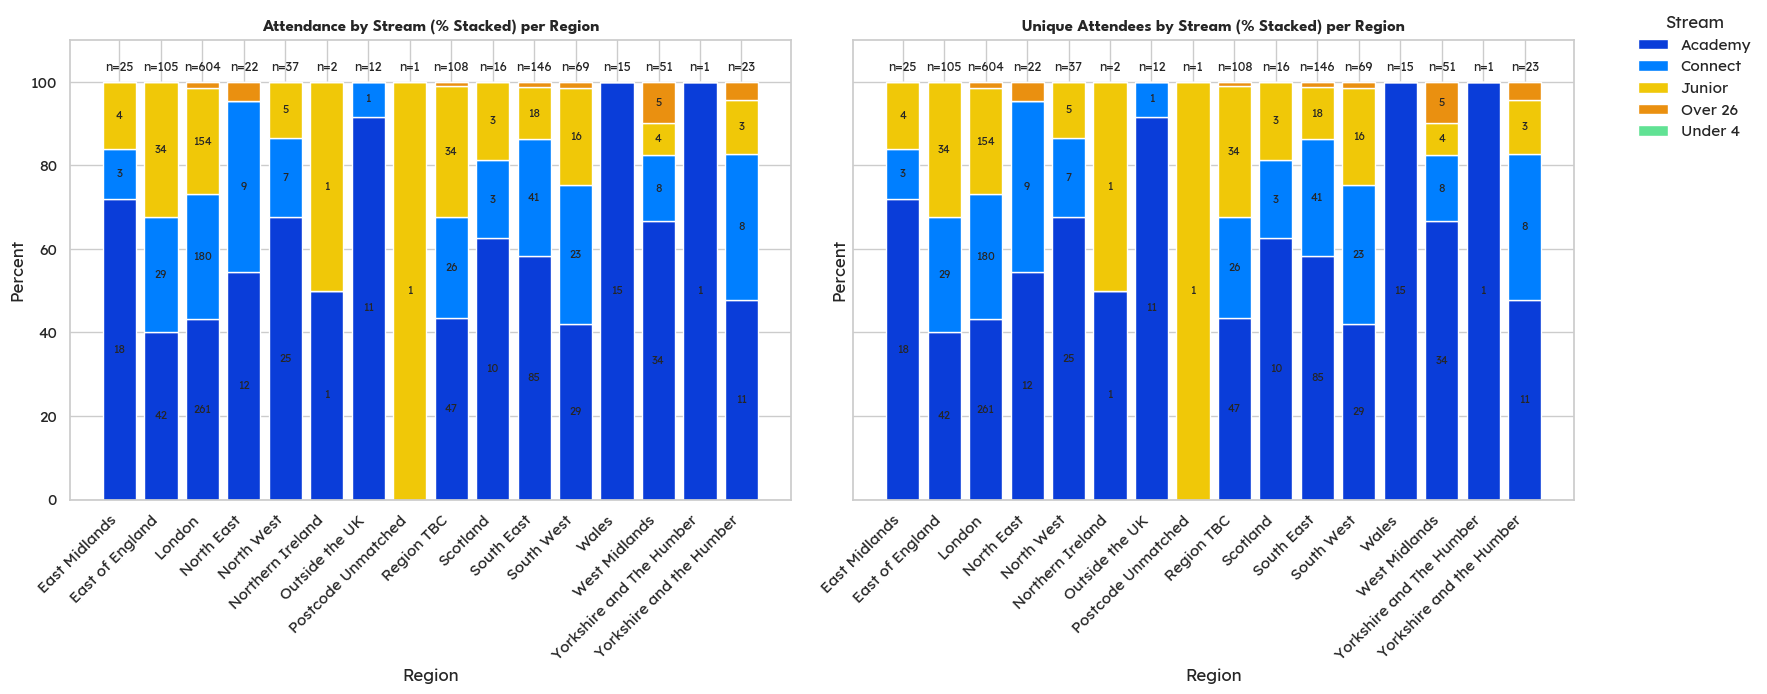

In [72]:
# --- SIDE-BY-SIDE: Attendance vs Unique Attendance (% stacked) ---

import numpy as np
import matplotlib.pyplot as plt

# Optional: if you use a custom fonts dict elsewhere, keep it; otherwise set a safe default
try:
    _ = fonts["headers"]
except Exception:
    fonts = {"headers": None}

# 1) Build pivot tables

# Left chart: raw attendance counts
pivot_counts = Att_v3.pivot_table(
    index="Region", # rows
    columns="Stream", # columns
    values="Record_ID",     # <-- your original count field (# what to count)
    aggfunc="count", # distinct count
    fill_value=0
)

# Right chart: unique people (distinct)- If your unique column is named differently, change here:
pivot_unique = Att_v3.pivot_table(
    index="Region",
    columns="Stream",
    values="Record_ID (Unique)",    # <-- distinct people field
    aggfunc="count",
    fill_value=0
)

# Helper: convert a pivot to % by row + return row totals (n)
def to_percent_df(pivot_df):
    pct = pivot_df.copy()
    totals = pct.sum(axis=1)
    # avoid div by zero (if any region totals are 0)
    safe_totals = totals.replace(0, 1)
    pct = pct.div(safe_totals, axis=0) * 100
    return pct, totals

pct_counts, totals_counts = to_percent_df(pivot_counts)
pct_unique, totals_unique = to_percent_df(pivot_unique)

# Keep columns (streams) in a stable order across both charts
value_cols = list(pct_counts.columns)

# 2) Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

plots = [
    ("Attendance by Stream (% Stacked) per Region", pct_counts, totals_counts, pivot_counts, axes[0]),
    ("Unique Attendees by Stream (% Stacked) per Region", pct_unique, totals_unique, pivot_unique, axes[1]),
]

for title, pct_df, row_totals, base_counts_df, ax in plots:
    index_labels = pct_df.index
    bottom = np.zeros(len(pct_df))

    # Stacked bars
    for c in value_cols:
        ax.bar(index_labels, pct_df[c], bottom=bottom, label=c)
        bottom += pct_df[c].values

    # Totals above each bar
    for i, total in enumerate(row_totals.values):
        ax.text(i, 102, f"n={int(total)}",
                ha="center", va="bottom", fontsize=9, fontweight="bold")

    # Segment counts inside bars when segment ≥ threshold%
    threshold = 7  # percent
    cum = np.zeros(len(pct_df))
    for c in value_cols:
        heights = pct_df[c].values
        counts = base_counts_df[c].values  # use the raw counts for labels
        for i, (h, cnt) in enumerate(zip(heights, counts)):
            if h >= threshold:
                y = cum[i] + h / 2.0
                ax.text(i, y, str(int(cnt)), ha="center", va="center", fontsize=8)
        cum += heights

    ax.set_title(title, fontname=fonts["headers"])
    ax.set_xlabel("Region")
    ax.set_ylabel("Percent")
    ax.set_xticklabels(index_labels, rotation=45, ha="right")
    ax.set_ylim(0, 110)

# One legend for both (based on left axis handles)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Stream", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

plt.tight_layout()
plt.show()

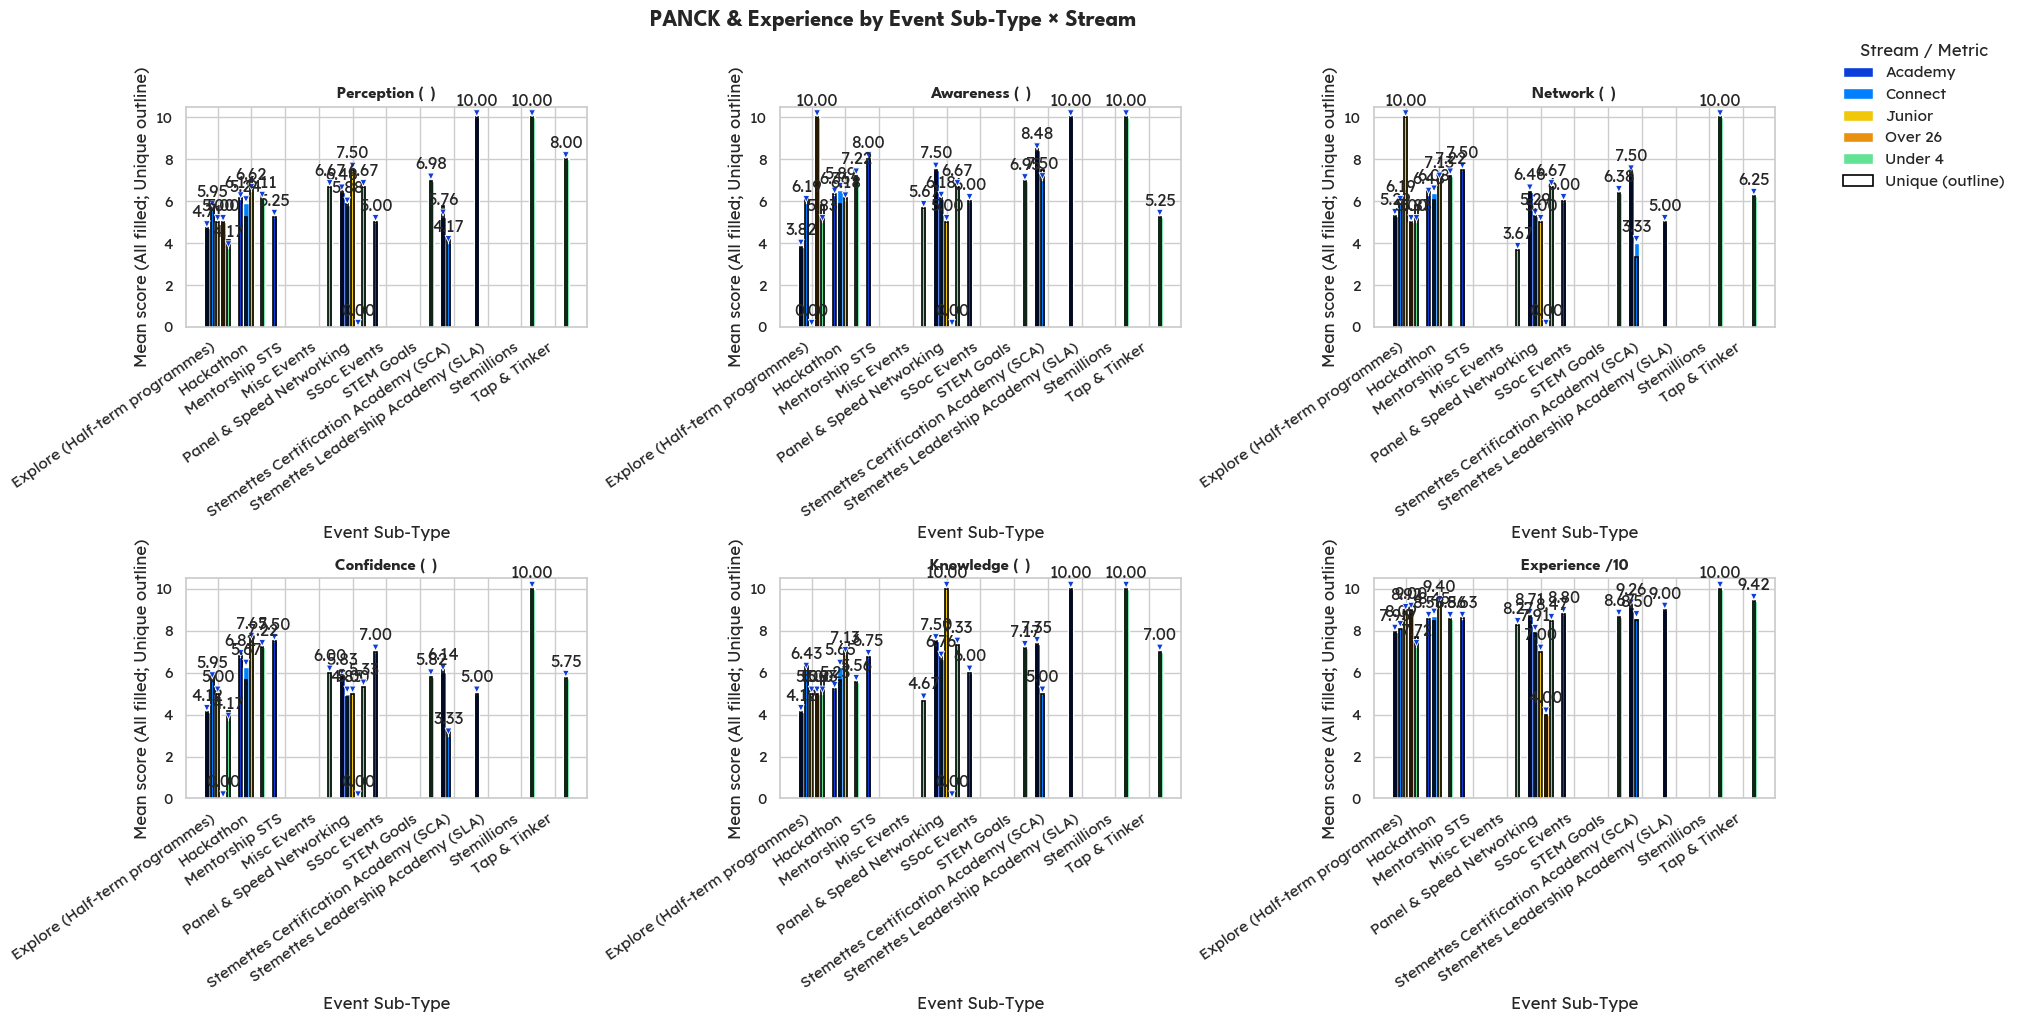

In [73]:
# ==== Imports (only if not already imported) ====
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ==== 1) Likert mapping + robust numeric coercion ====
LIKERT_MAP = {
    'Improved a lot': 10,
    'Improved a little': 5,
    'Not changed': 0,
    'Become worse': -5
}
LIKERT_REGEX = re.compile(r'Improved a lot|Improved a little|Not changed|Become worse')

def coerce_metric_numeric(series: pd.Series) -> pd.Series:
    """
    Return a float Series suitable for aggregation.
    Handles:
      - already numeric
      - numeric strings
      - single Likert text
      - concatenated Likert phrases
    """
    if series.dtype.kind in "iuf":
        return series.astype("float64")

    s = series.astype("string").str.strip()

    # try to coerce straight to numeric first
    num = pd.to_numeric(s, errors="coerce")
    if num.notna().any():
        return num.astype("float64")

    # else parse Likert (including concatenations)
    def map_concat(val):
        if pd.isna(val):
            return np.nan
        tokens = LIKERT_REGEX.findall(str(val))
        if not tokens:
            return np.nan
        vals = [LIKERT_MAP[t] for t in tokens]
        return float(np.mean(vals)) if vals else np.nan

    return s.apply(map_concat).astype("float64")

# ==== 2) Grouping helpers: ALL vs UNIQUE-per-person means ====
def mean_tables(df, metric, subtype_col, stream_col, unique_id):
    """
    Returns (mean_all, mean_unique) as wide tables (index=subtype, columns=streams).
    Ensures the metric is numeric before aggregation.
    """
    cols_needed = [subtype_col, stream_col, unique_id, metric]
    d = df[cols_needed].copy()

    # ensure numeric metric for aggregation
    d[metric] = coerce_metric_numeric(d[metric])
    d = d.dropna(subset=[metric, subtype_col, stream_col])

    if d.empty:
        return (pd.DataFrame(), pd.DataFrame())

    # ALL responses mean
    mean_all = (
        d.groupby([subtype_col, stream_col])[metric]
         .mean()
         .unstack(stream_col)
    )

    # UNIQUE-per-person mean:
    #   1) average duplicates per (subtype, stream, person)
    per_person = (
        d.groupby([subtype_col, stream_col, unique_id])[metric]
         .mean()
         .reset_index()
    )
    #   2) average those per-person means across people
    mean_unique = (
        per_person.groupby([subtype_col, stream_col])[metric]
                  .mean()
                  .unstack(stream_col)
    )

    return (mean_all, mean_unique)

# ==== 3) Plot helper: grouped bars + thin unique overlay + arrow labels ====
def plot_grouped_with_outline(ax, mean_all, mean_unique, title, brand_colours, header_font=None,
                              stream_order=None, rotate_xticks=45):
    """
    mean_all / mean_unique: DataFrames with index = Event Sub-Type, columns = Streams
    Draws filled bars (ALL) + thin outline overlay (UNIQUE) with arrow labels.
    """
    if mean_all.empty:
        ax.set_title(f"{title}\n(No data)")
        ax.axis('off')
        return

    # align uniques to all index/columns
    mean_unique = mean_unique.reindex_like(mean_all)

    # choose column (stream) order
    cols = list(mean_all.columns)
    if stream_order:
        cols = [c for c in stream_order if c in cols] + [c for c in cols if c not in stream_order]

    # positions
    x = np.arange(len(mean_all.index))
    n_series = len(cols)
    bar_width = max(0.10, min(0.80 / max(n_series, 1), 0.2))

    # color map per stream
    color_map = {}
    for i, c in enumerate(cols):
        color_map[c] = brand_colours[i % len(brand_colours)]

    # draw bars
    for i, col in enumerate(cols):
        offsets = x + (i - (n_series - 1) / 2) * bar_width

        heights = mean_all[col].to_numpy()
        ax.bar(
            offsets,
            heights,
            width=bar_width,
            label=col,
            color=color_map[col]
        )

        uniq_vals = mean_unique[col].to_numpy()
        ax.bar(
            offsets,
            uniq_vals,
            width=bar_width * 0.45,  # thinner overlay
            fill=False,
            linewidth=1.2,
            edgecolor="black"
        )

        # arrow labels for unique mean
        for xpos, h, u in zip(offsets, heights, uniq_vals):
            if np.isfinite(u) and np.isfinite(h):
                ax.annotate(
                    f"{u:.2f}",
                    xy=(xpos, h),
                    xytext=(0, 6),
                    textcoords="offset points",
                    ha="center", va="bottom",
                    arrowprops=dict(arrowstyle="-|>", lw=0.6)
                )

    # labels & title
    ax.set_xticks(x, mean_all.index, rotation=rotate_xticks, ha="right")
    ax.set_ylabel("Mean score (All filled; Unique outline)")
    if header_font:
        ax.set_title(title, fontname=header_font, fontweight="bold")
    else:
        ax.set_title(title, fontweight="bold")

# ==== 4) Facet: 3x2 of the requested metrics ====
def facet_panck_experience(
    df,
    brand_colours,
    header_font=None,
    subtype_col="Event Sub-Type",
    stream_col="Stream_2",               # adjust if your stream column is named differently
    unique_id="Record_ID (Unique)",
    stream_order=None                    # e.g. ["Under 4", "5–7", "8–10", ...] or None
):
    """
    Builds a 3x2 facet:
      1) Perception Δ
      2) Awareness Δ
      3) Network Δ
      4) Confidence Δ
      5) Knowledge Δ
      6) Experience /10
    x = Event Sub-Type, grouped by Stream (brand colours), with Unique overlay.
    """

    metrics = [
        ("Perception (Δ)",  "STEAM Perception_After"),
        ("Awareness (Δ)",   "STEAM Awareness_After"),
        ("Network (Δ)",     "STEAM Network_After"),
        ("Confidence (Δ)",  "STEAM Confidence_After"),
        ("Knowledge (Δ)",   "STEAM Knowledge_After"),
        ("Experience /10",  "Experience /10"),
    ]

    # clean index axis order (sort Event Sub-Type)
    # we’ll compute per-metric tables, but use a common subtype order (A–Z) for consistency
    subtypes = (
        df[subtype_col]
        .dropna()
        .astype("string")
        .str.strip()
        .unique()
    )
    subtype_order = sorted([s for s in subtypes if s])

    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=False)
    axes = axes.ravel()

    # for unified legend: gather 1st axis’ handles later
    first_ax = axes[0]

    for ax, (nice_name, col_name) in zip(axes, metrics):
        # compute wide tables
        mean_all, mean_uni = mean_tables(df, col_name, subtype_col, stream_col, unique_id)

        # enforce common subtype order if present
        if not mean_all.empty:
            mean_all = mean_all.reindex(subtype_order).dropna(how="all")
        if not mean_uni.empty:
            mean_uni = mean_uni.reindex(subtype_order).dropna(how="all")

        plot_grouped_with_outline(
            ax, mean_all, mean_uni,
            title=nice_name,
            brand_colours=brand_colours,
            header_font=header_font,
            stream_order=stream_order,
            rotate_xticks=35
        )
        ax.set_xlabel("Event Sub-Type")

    # single combined legend (streams + unique overlay proxy)
    handles, labels = first_ax.get_legend_handles_labels()
    unique_proxy = Patch(facecolor='none', edgecolor='black', linewidth=1.2, label='Unique (outline)')
    handles.append(unique_proxy)
    labels.append('Unique (outline)')

    fig.legend(handles, labels, title="Stream / Metric",
               bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

    if header_font:
        fig.suptitle("PANCK & Experience by Event Sub-Type × Stream", fontname=header_font, fontsize=16, fontweight="bold", y=1.02)
    else:
        fig.suptitle("PANCK & Experience by Event Sub-Type × Stream", fontsize=16, fontweight="bold", y=1.02)

    plt.tight_layout()
    plt.show()

# ==== 5) RUN ====
#Ensure you pass your cleaned feedback DataFrame (e.g., Fb_new) and your brand colours + fonts dict
#Example:
facet_panck_experience(
     Fb_new,
     brand_colours=brand_colours,
     header_font=fonts.get("headers"),
     subtype_col="Event Sub-Type",
     stream_col="Stream_2",            # or "Stream" if that's your column
     unique_id="Record_ID (Unique)",
     stream_order=None                 # or a custom list if you have a preferred order
 )

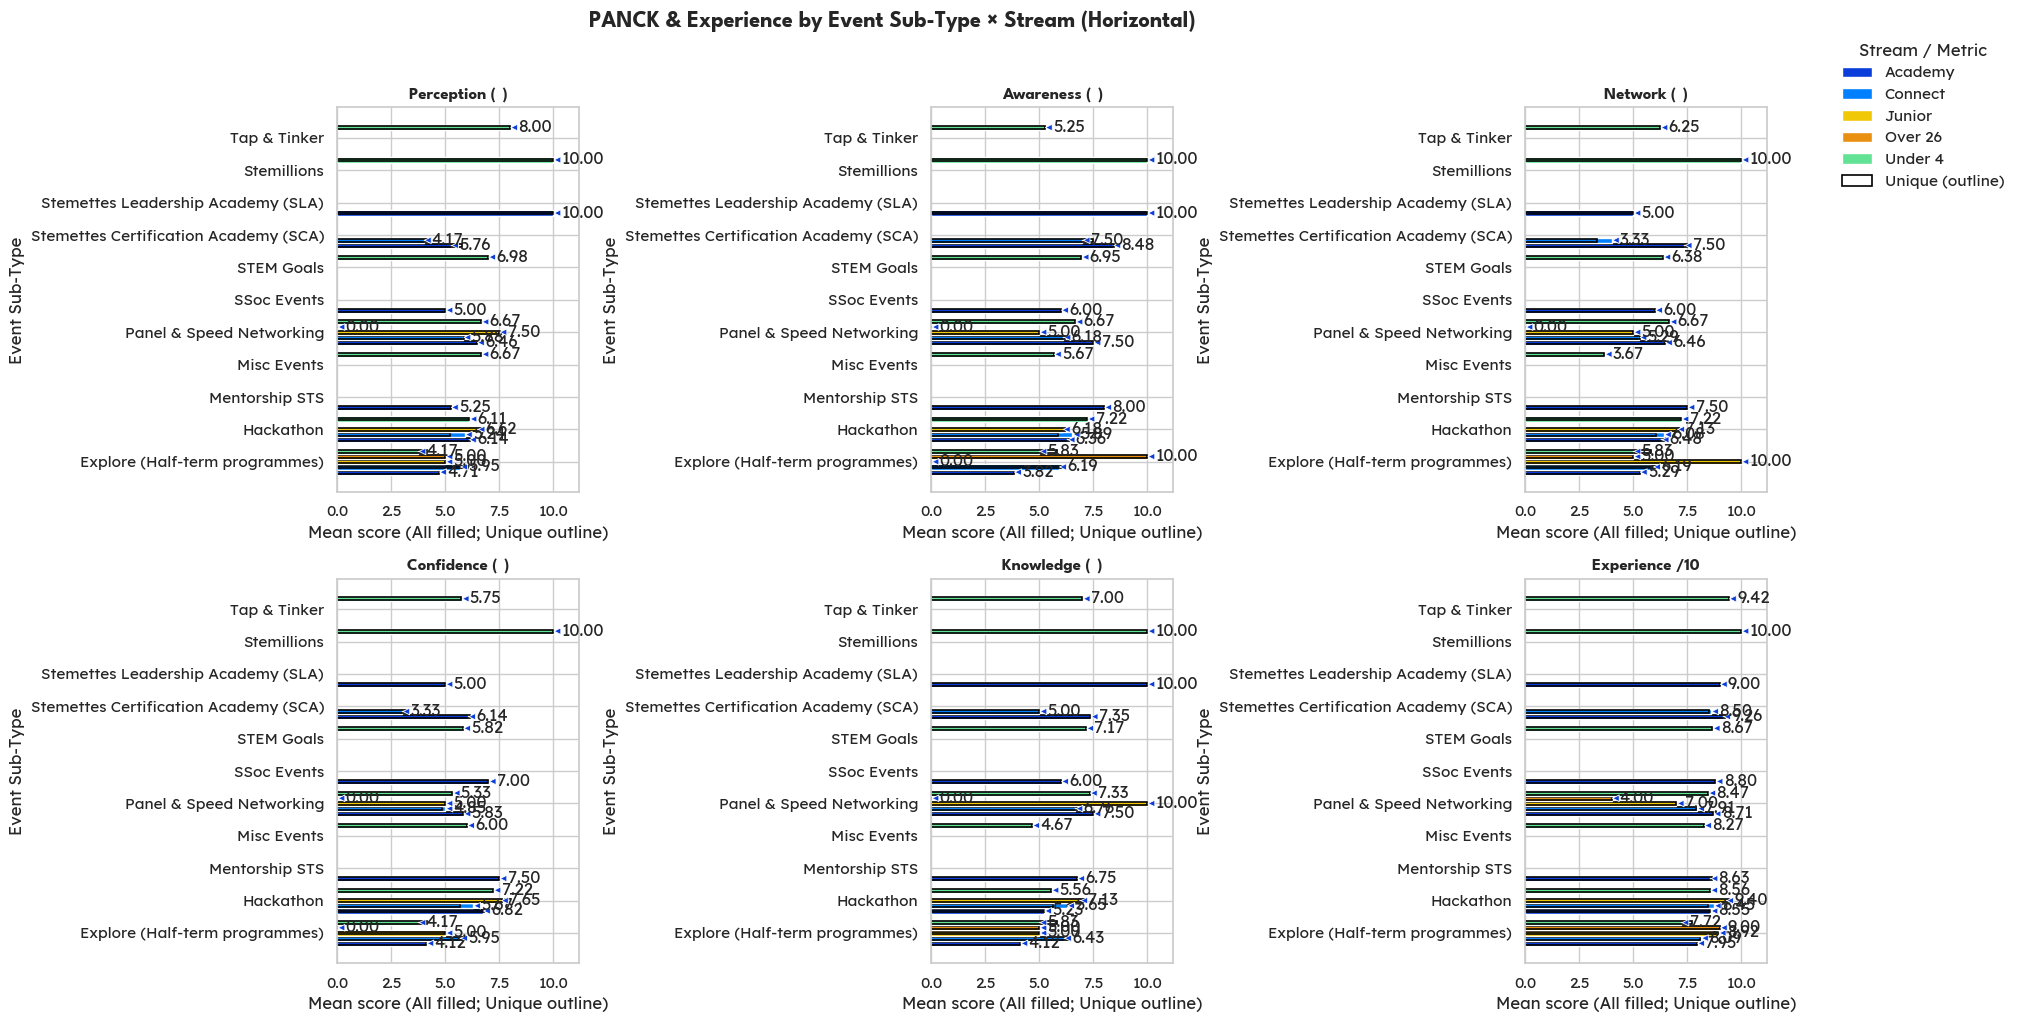

In [74]:
# === Horizontal helper: grouped barh + thin unique outline + arrow labels ===
def plot_grouped_with_outline_h(
    ax, mean_all, mean_unique, title, brand_colours, header_font=None,
    stream_order=None
):
    """
    Horizontal version:
      y = Event Sub-Type categories
      grouped bars = Streams
      filled = ALL mean; outline + arrow = UNIQUE mean
    """
    if mean_all.empty:
        ax.set_title(f"{title}\n(No data)")
        ax.axis('off')
        return

    # Align uniques to ALL table (index & columns)
    mean_unique = mean_unique.reindex_like(mean_all)

    # Column (stream) order
    cols = list(mean_all.columns)
    if stream_order:
        cols = [c for c in stream_order if c in cols] + [c for c in cols if c not in stream_order]

    # Positions (y = categories)
    y = np.arange(len(mean_all.index))
    n_series = len(cols)
    bar_h = max(0.10, min(0.80 / max(n_series, 1), 0.22))  # bar height per stream within each category

    # Color map per stream
    color_map = {c: brand_colours[i % len(brand_colours)] for i, c in enumerate(cols)}

    # Track max x for nice padding
    xmax = 0.0

    for i, col in enumerate(cols):
        offsets = y + (i - (n_series - 1) / 2) * bar_h

        widths = mean_all[col].to_numpy(dtype=float)
        h_unique = mean_unique[col].to_numpy(dtype=float)

        # Filled = ALL mean
        ax.barh(
            offsets,
            widths,
            height=bar_h,
            label=col,
            color=color_map[col]
        )

        # Thin outline = UNIQUE mean
        ax.barh(
            offsets,
            h_unique,
            height=bar_h * 0.55,   # a bit thinner
            fill=False,
            linewidth=1.2,
            edgecolor="black"
        )

        # Arrow labels (unique values) to the right of the filled bar
        for ypos, w, u in zip(offsets, widths, h_unique):
            if np.isfinite(u) and np.isfinite(w):
                ax.annotate(
                    f"{u:.2f}",
                    xy=(w, ypos),
                    xytext=(6, 0),
                    textcoords="offset points",
                    ha="left", va="center",
                    arrowprops=dict(arrowstyle="-|>", lw=0.6)
                )
                xmax = max(xmax, w, u)

    # Labels & title
    ax.set_yticks(y, mean_all.index)
    ax.set_xlabel("Mean score (All filled; Unique outline)")
    ax.set_ylabel("Event Sub-Type")
    if header_font:
        ax.set_title(title, fontname=header_font, fontweight="bold")
    else:
        ax.set_title(title, fontweight="bold")

    # Add a little headroom on x for the arrow labels
    ax.set_xlim(0, xmax * 1.12 if np.isfinite(xmax) and xmax > 0 else None)


# === Facet (3×2) with horizontal bars: PANCK + Experience ===
def facet_panck_experience_horizontal(
    df,
    brand_colours,
    header_font=None,
    subtype_col="Event Sub-Type",
    stream_col="Stream_2",
    unique_id="Record_ID (Unique)",
    stream_order=None
):
    metrics = [
        ("Perception (Δ)",  "STEAM Perception_After"),
        ("Awareness (Δ)",   "STEAM Awareness_After"),
        ("Network (Δ)",     "STEAM Network_After"),
        ("Confidence (Δ)",  "STEAM Confidence_After"),
        ("Knowledge (Δ)",   "STEAM Knowledge_After"),
        ("Experience /10",  "Experience /10"),
    ]

    # Consistent y-axis order (Event Sub-Type) across panels
    subtype_order = (
        df[subtype_col]
          .dropna()
          .astype("string")
          .str.strip()
          .sort_values()
          .unique()
          .tolist()
    )

    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=False, sharey=False)
    axes = axes.ravel()

    first_ax = axes[0]

    for ax, (nice_name, col_name) in zip(axes, metrics):
        mean_all, mean_uni = mean_tables(df, col_name, subtype_col, stream_col, unique_id)

        if not mean_all.empty:
            mean_all = mean_all.reindex(subtype_order).dropna(how="all")
        if not mean_uni.empty:
            mean_uni = mean_uni.reindex(subtype_order).dropna(how="all")

        plot_grouped_with_outline_h(
            ax, mean_all, mean_uni,
            title=nice_name,
            brand_colours=brand_colours,
            header_font=header_font,
            stream_order=stream_order
        )

    # Build a single legend (streams + unique overlay proxy)
    handles, labels = first_ax.get_legend_handles_labels()
    unique_proxy = Patch(facecolor='none', edgecolor='black', linewidth=1.2, label='Unique (outline)')
    handles.append(unique_proxy)
    labels.append('Unique (outline)')

    fig.legend(handles, labels, title="Stream / Metric",
               bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

    supt = "PANCK & Experience by Event Sub-Type × Stream (Horizontal)"
    if header_font:
        fig.suptitle(supt, fontname=header_font, fontsize=16, fontweight="bold", y=1.02)
    else:
        fig.suptitle(supt, fontsize=16, fontweight="bold", y=1.02)

    plt.tight_layout()
    plt.show()


# === RUN ===
facet_panck_experience_horizontal(
     Fb_new,
     brand_colours=brand_colours,
     header_font=fonts.get("headers"),
     subtype_col="Event Sub-Type",
     stream_col="Stream_2",          # adjust if needed
     unique_id="Record_ID (Unique)",
     stream_order=None               # or a custom list for a fixed order
)

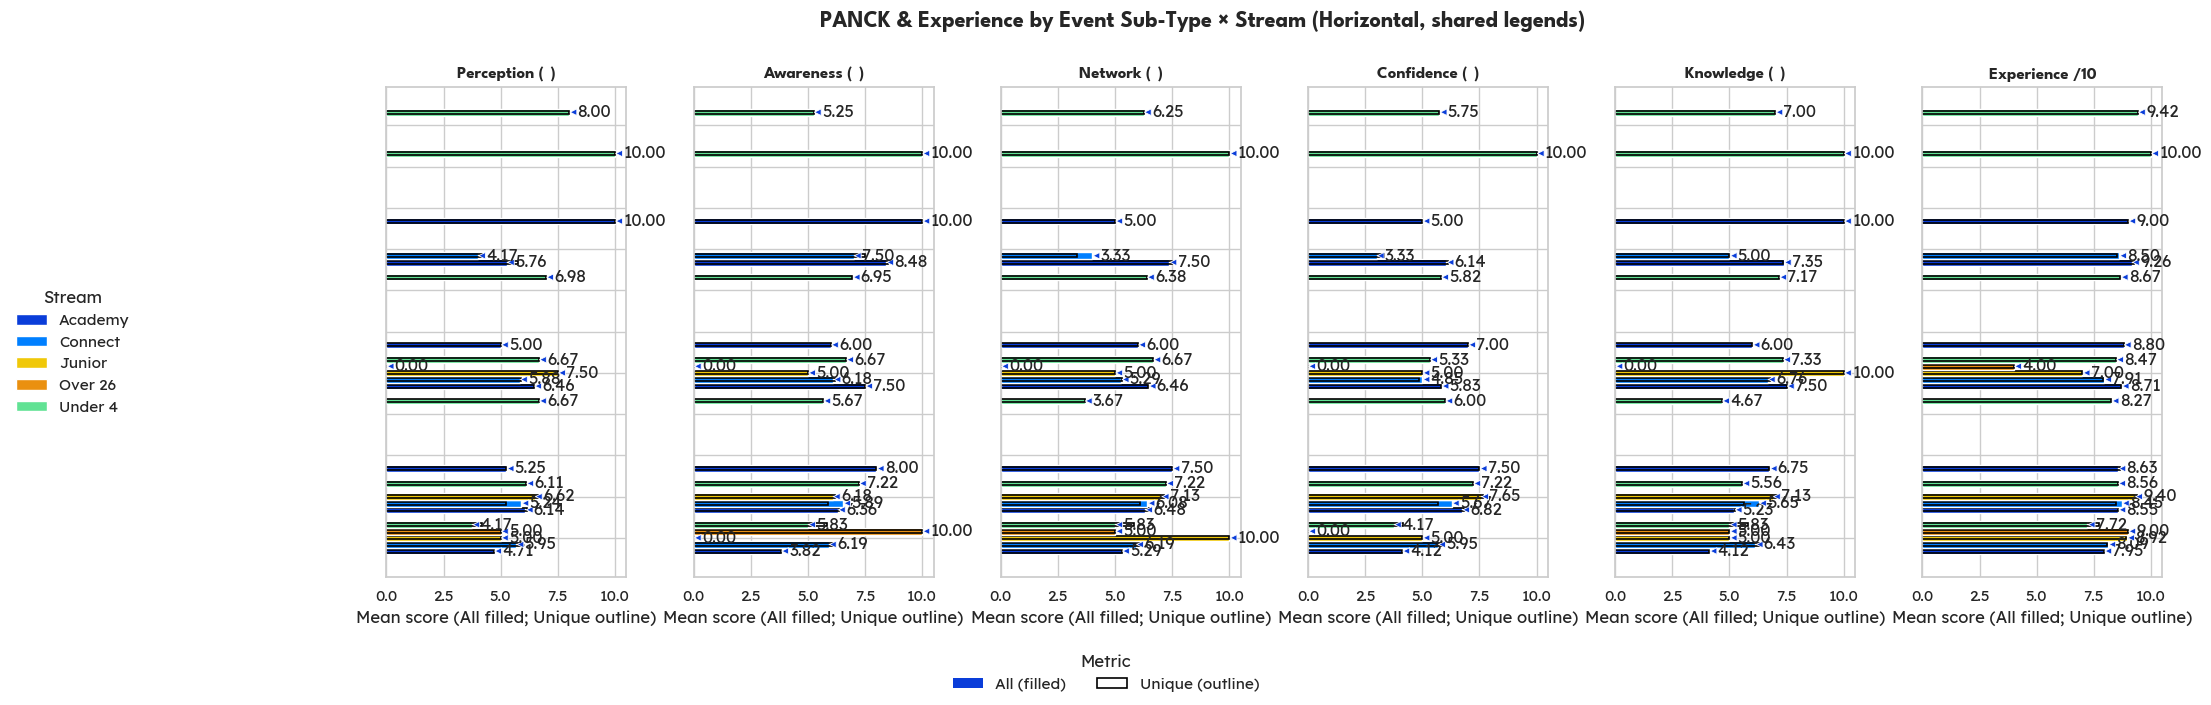

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ---------- numeric coercion for metrics (handles Likert strings & concatenations) ----------
import re
LIKERT_MAP = {
    'Improved a lot': 10,
    'Improved a little': 5,
    'Not changed': 0,
    'Become worse': -5
}
LIKERT_REGEX = re.compile(r'Improved a lot|Improved a little|Not changed|Become worse')

def coerce_metric_numeric(series: pd.Series) -> pd.Series:
    if series.dtype.kind in "iuf":
        return series.astype("float64")
    s = series.astype("string").str.strip()
    num = pd.to_numeric(s, errors="coerce")
    if num.notna().any() and num.notna().sum() >= s.notna().sum() * 0.3:
        return num.astype("float64")
    def map_concat(val):
        if pd.isna(val): return np.nan
        tokens = LIKERT_REGEX.findall(str(val))
        if not tokens: return np.nan
        vals = [LIKERT_MAP[t] for t in tokens]
        return float(np.mean(vals)) if vals else np.nan
    return s.apply(map_concat).astype("float64")

# ---------- groupers: ALL vs. UNIQUE-per-person ----------
def mean_tables(df, metric, subtype_col, stream_col, unique_id):
    cols_needed = [subtype_col, stream_col, unique_id, metric]
    missing = [c for c in cols_needed if c not in df.columns]
    if missing:
        print(f"[mean_tables] Missing columns: {missing}")
        return (pd.DataFrame(), pd.DataFrame())

    d = df[cols_needed].copy()
    d[metric] = coerce_metric_numeric(d[metric])
    d = d.dropna(subset=[metric, subtype_col, stream_col])
    if d.empty:
        print(f"[mean_tables] No rows after cleaning for metric '{metric}'.")
        return (pd.DataFrame(), pd.DataFrame())

    mean_all = d.groupby([subtype_col, stream_col])[metric].mean().unstack(stream_col)

    per_person = d.groupby([subtype_col, stream_col, unique_id])[metric].mean().reset_index()
    mean_unique = per_person.groupby([subtype_col, stream_col])[metric].mean().unstack(stream_col)
    return (mean_all, mean_unique)

# ---------- HORIZONTAL grouped bars + unique-outline overlay ----------
def plot_grouped_with_outline_h(
    ax, mean_all, mean_unique, title, brand_colours, header_font=None, stream_order=None
):
    if mean_all.empty:
        ax.set_title(f"{title}\n(No data)")
        ax.axis('off')
        return

    mean_unique = mean_unique.reindex_like(mean_all)

    cols = list(mean_all.columns)
    if stream_order:
        cols = [c for c in stream_order if c in cols] + [c for c in cols if c not in stream_order]

    y = np.arange(len(mean_all.index))
    n_series = len(cols)
    bar_h = max(0.10, min(0.80 / max(n_series, 1), 0.2))

    color_map = {c: brand_colours[i % len(brand_colours)] for i, c in enumerate(cols)}

    for i, col in enumerate(cols):
        offsets = y + (i - (n_series - 1) / 2) * bar_h
        widths = mean_all[col].to_numpy()
        ax.barh(offsets, widths, height=bar_h, label=col, color=color_map[col])

        uniq_vals = mean_unique[col].to_numpy()
        ax.barh(offsets, uniq_vals, height=bar_h*0.45, fill=False, linewidth=1.2, edgecolor="black")

        for ypos, w, u in zip(offsets, widths, uniq_vals):
            if np.isfinite(u) and np.isfinite(w):
                ax.annotate(
                    f"{u:.2f}",
                    xy=(w, ypos),
                    xytext=(6, 0),
                    textcoords="offset points",
                    va="center", ha="left",
                    arrowprops=dict(arrowstyle="-|>", lw=0.6)
                )

    ax.set_yticks(y, mean_all.index)
    ax.set_xlabel("Mean score (All filled; Unique outline)")
    if header_font:
        ax.set_title(title, fontname=header_font, fontweight="bold")
    else:
        ax.set_title(title, fontweight="bold")

# ---------- ONE ROW, SHARED LEGENDS ----------
def facet_panck_experience_horizontal_row(
    df,
    brand_colours,
    header_font=None,
    subtype_col="Event Sub-Type",
    stream_col="Stream_2",
    unique_id="Record_ID (Unique)",
    stream_order=None
):
    metrics = [
        ("Perception (Δ)",  "STEAM Perception_After"),
        ("Awareness (Δ)",   "STEAM Awareness_After"),
        ("Network (Δ)",     "STEAM Network_After"),
        ("Confidence (Δ)",  "STEAM Confidence_After"),
        ("Knowledge (Δ)",   "STEAM Knowledge_After"),
        ("Experience /10",  "Experience /10"),
    ]

    # y-axis order (Event Sub-Type)
    if subtype_col not in df.columns:
        raise KeyError(f"Column '{subtype_col}' not found in DataFrame.")
    subtype_order = (
        df[subtype_col].dropna().astype("string").str.strip().sort_values().unique().tolist()
    )

    fig, axes = plt.subplots(1, 6, figsize=(24, 7), sharey=True)
    axes = np.atleast_1d(axes)

    first_ax = axes[0]
    any_plotted = False

    for i, (ax, (nice_name, col_name)) in enumerate(zip(axes, metrics)):
        mean_all, mean_uni = mean_tables(df, col_name, subtype_col, stream_col, unique_id)

        if not mean_all.empty:
            mean_all = mean_all.reindex(subtype_order).dropna(how="all")
        if not mean_uni.empty:
            mean_uni = mean_uni.reindex(subtype_order).dropna(how="all")

        if mean_all.empty:
            ax.set_title(f"{nice_name}\n(No data)")
            ax.axis('off')
        else:
            any_plotted = True
            plot_grouped_with_outline_h(
                ax, mean_all, mean_uni, nice_name, brand_colours, header_font, stream_order
            )

        if i > 0:
            ax.set_ylabel("")
            ax.set_yticklabels([])

    if not any_plotted:
        fig.suptitle("No data available for the selected metrics/columns.")
        plt.show()
        return

    # Stream legend from first axes
    stream_handles, stream_labels = first_ax.get_legend_handles_labels()
    # Metric legend proxies
    filled_proxy = Patch(facecolor=brand_colours[0], edgecolor='none', label='All (filled)')
    outline_proxy = Patch(facecolor='none', edgecolor='black', linewidth=1.2, label='Unique (outline)')

    fig.legend(stream_handles, stream_labels, title="Stream",
               loc="center left", bbox_to_anchor=(0.0, 0.5), frameon=False)

    fig.legend([filled_proxy, outline_proxy], ["All (filled)", "Unique (outline)"],
               title="Metric", loc="lower center", ncol=2, frameon=False)

    supt = "PANCK & Experience by Event Sub-Type × Stream (Horizontal, shared legends)"
    if header_font:
        fig.suptitle(supt, fontname=header_font, fontsize=16, fontweight="bold", y=0.99)
    else:
        fig.suptitle(supt, fontsize=16, fontweight="bold", y=0.99)

    plt.subplots_adjust(left=0.16, bottom=0.18, wspace=0.28)
    plt.show()

# ---------- RUN (adjust column names if needed) ----------
facet_panck_experience_horizontal_row(
    Fb_new,
    brand_colours=brand_colours,
    header_font=fonts.get("headers"),
    subtype_col="Event Sub-Type",
    stream_col="Stream_2",
    unique_id="Record_ID (Unique)",
    stream_order=None
)

In [76]:
def facet_panck_experience_horizontal_row(
    df,
    brand_colours,
    header_font=None,
    subtype_col="Event Sub-Type",
    stream_col="Stream_2",
    unique_id="Record_ID (Unique)",
    stream_order=None
):
    metrics = [
        ("Perception (Δ)",  "STEAM Perception_After"),
        ("Awareness (Δ)",   "STEAM Awareness_After"),
        ("Network (Δ)",     "STEAM Network_After"),
        ("Confidence (Δ)",  "STEAM Confidence_After"),
        ("Knowledge (Δ)",   "STEAM Knowledge_After"),
        ("Experience /10",  "Experience /10"),
    ]

    if subtype_col not in df.columns:
        raise KeyError(f"Column '{subtype_col}' not found in DataFrame.")

    subtype_order = (
        df[subtype_col].dropna().astype("string").str.strip().sort_values().unique().tolist()
    )

    fig, axes = plt.subplots(1, 6, figsize=(24, 7), sharey=True)
    axes = np.atleast_1d(axes)

    first_ax = axes[0]
    any_plotted = False

    for i, (ax, (nice_name, col_name)) in enumerate(zip(axes, metrics)):
        mean_all, mean_uni = mean_tables(df, col_name, subtype_col, stream_col, unique_id)

        if not mean_all.empty:
            mean_all = mean_all.reindex(subtype_order).dropna(how="all")
        if not mean_uni.empty:
            mean_uni = mean_uni.reindex(subtype_order).dropna(how="all")

        if mean_all.empty:
            ax.set_title(f"{nice_name}\n(No data)")
            ax.axis('off')
        else:
            any_plotted = True
            plot_grouped_with_outline_h(
                ax, mean_all, mean_uni, nice_name, brand_colours, header_font, stream_order
            )

        # y-ticks only on the first subplot
        if i > 0:
            ax.set_ylabel("")
            ax.set_yticklabels([])

    if not any_plotted:
        fig.suptitle("No data available for the selected metrics/columns.")
        plt.show()
        return

    # ---- Combined bottom legend: Streams + Metric proxies ----
    stream_handles, stream_labels = first_ax.get_legend_handles_labels()
    filled_proxy  = Patch(facecolor=brand_colours[0], edgecolor='none', label='All (filled)')
    outline_proxy = Patch(facecolor='none', edgecolor='black', linewidth=1.2, label='Unique (outline)')

    all_handles = stream_handles + [filled_proxy, outline_proxy]
    all_labels  = stream_labels + ['All (filled)', 'Unique (outline)']

    fig.legend(
        all_handles, all_labels, title="Stream / Metric",
        loc="lower center", ncol=min(len(all_labels), 6), frameon=False,
        bbox_to_anchor=(0.5, 0.01)
    )

    # ---- Left-side figure label: “Event Sub-Type” ----
    fig.text(
        0.06, 0.5, "Event Sub-Type", rotation=90, va='center', ha='center',
        fontsize=12, fontweight='bold',
        fontname=(header_font if header_font else None)
    )

    # Title
    supt = "PANCK & Experience by Event Sub-Type × Stream (Horizontal, shared legends)"
    if header_font:
        fig.suptitle(supt, fontname=header_font, fontsize=16, fontweight="bold", y=0.98)
    else:
        fig.suptitle(supt, fontsize=16, fontweight="bold", y=0.98)

    # Layout: make room for left y-label and bottom legend
    plt.subplots_adjust(left=0.12, bottom=0.12, wspace=0.28)
    plt.show()

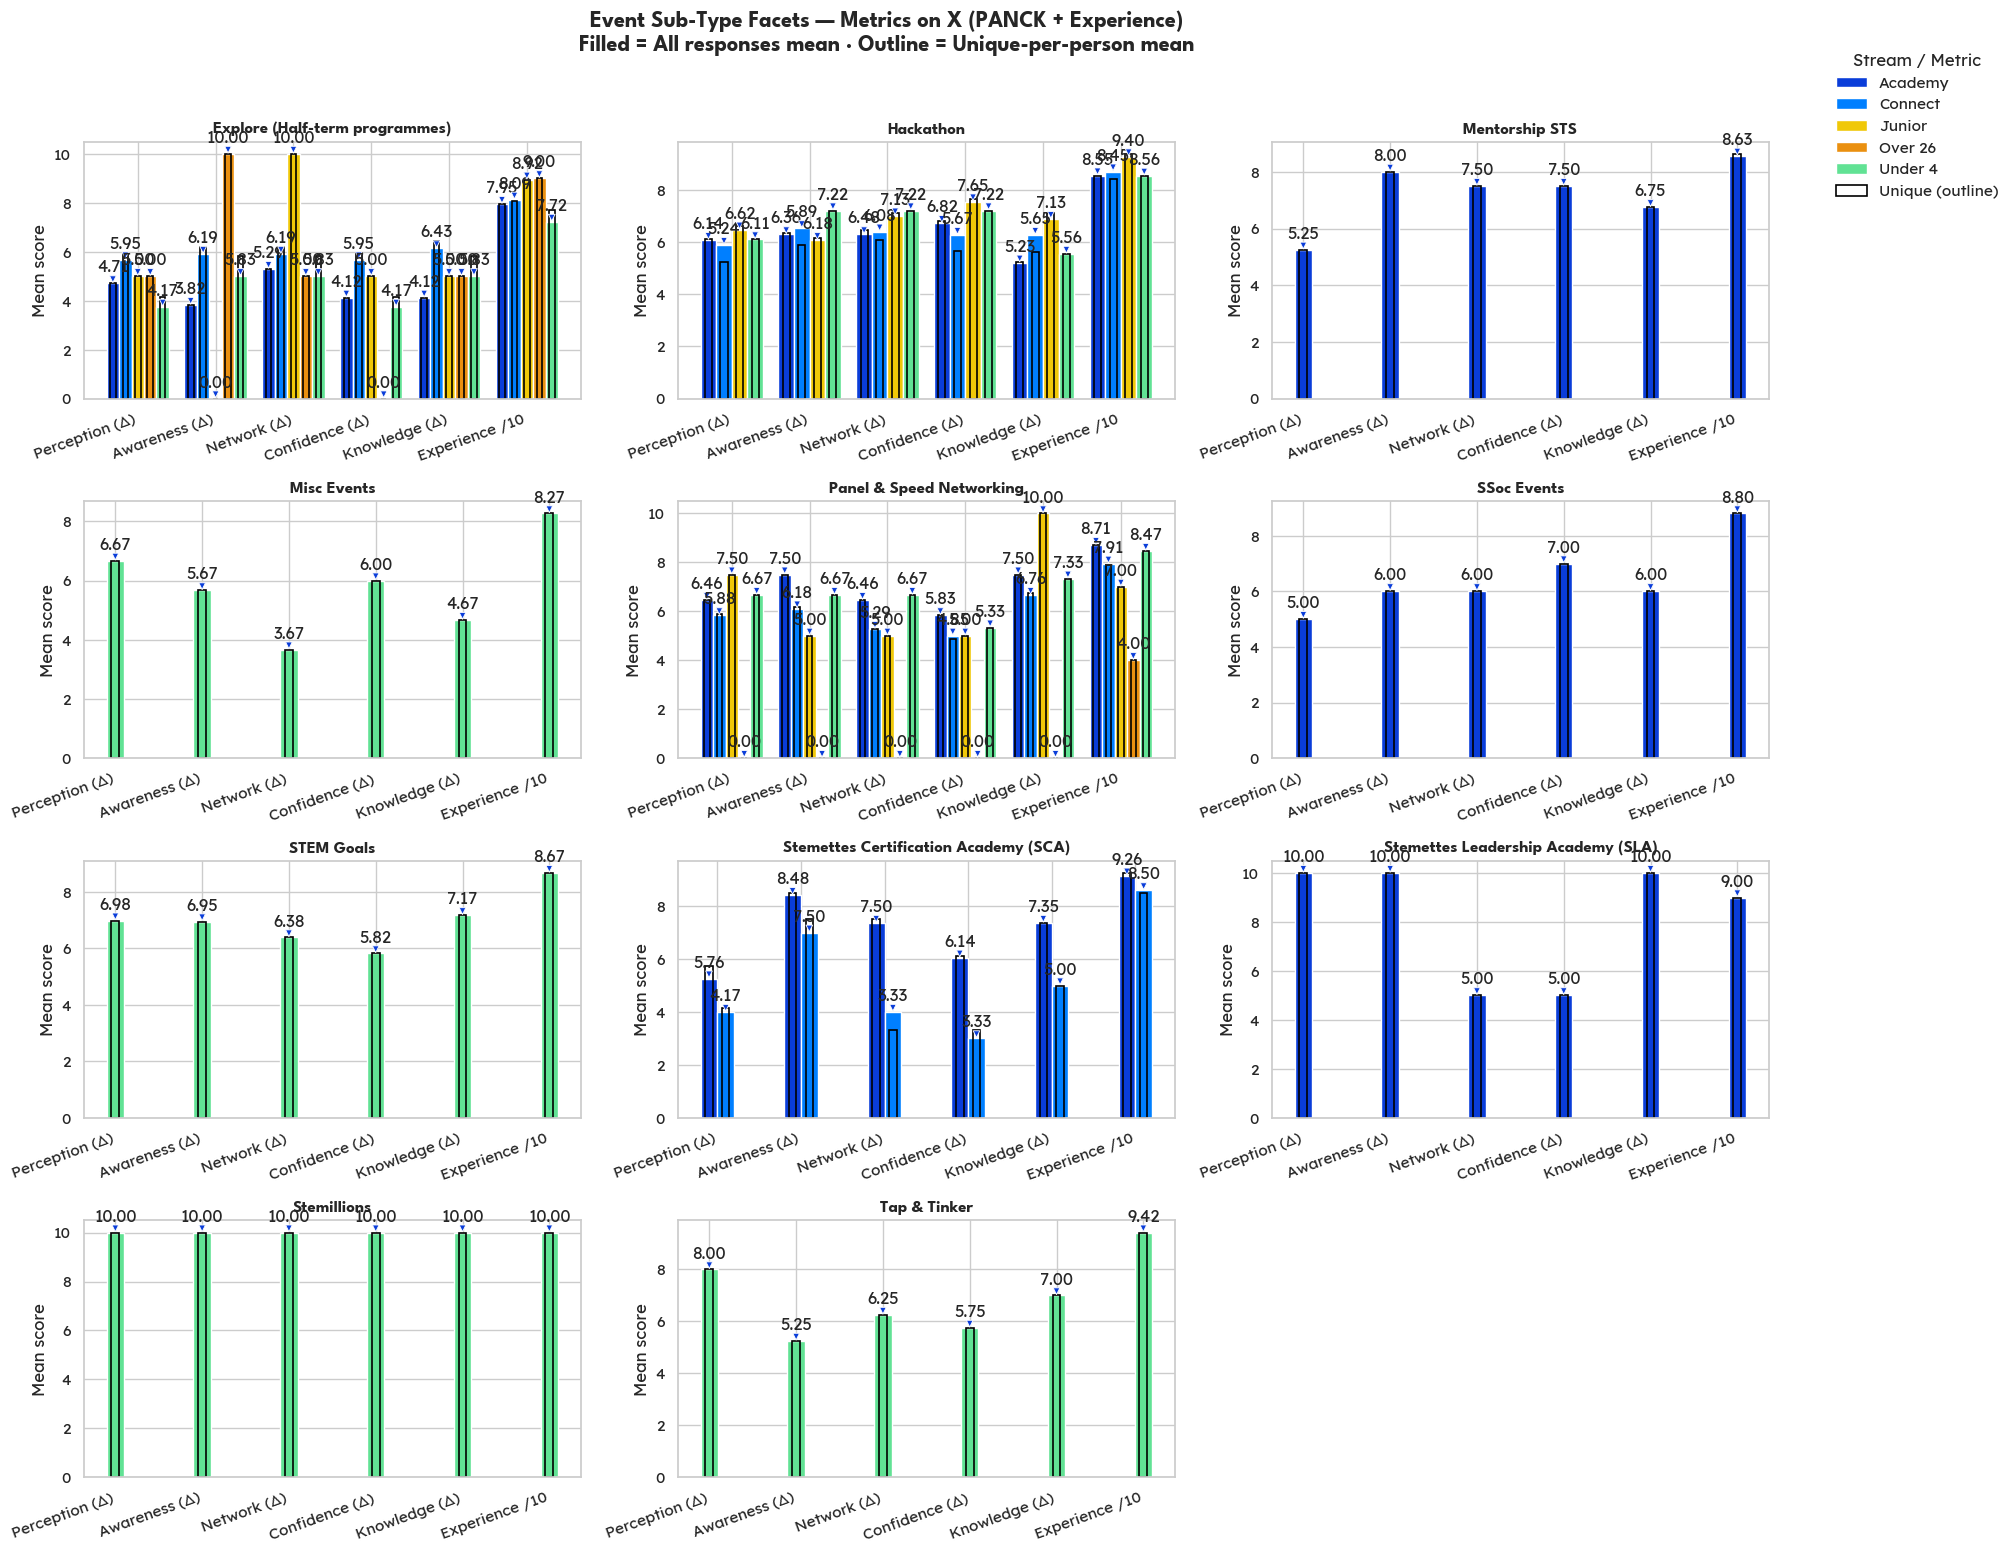

In [77]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Reuse LIKERT_MAP, LIKERT_REGEX, and coerce_metric_numeric from earlier

METRICS = [
    ("Perception (Δ)",  "STEAM Perception_After"),
    ("Awareness (Δ)",   "STEAM Awareness_After"),
    ("Network (Δ)",     "STEAM Network_After"),
    ("Confidence (Δ)",  "STEAM Confidence_After"),
    ("Knowledge (Δ)",   "STEAM Knowledge_After"),
    ("Experience /10",  "Experience /10"),
]

def subtype_metric_means(df, subtype, metrics, stream_col, subtype_col, unique_id):
    """
    For a given Event Sub-Type, return two dicts:
      all_means[metric_display]    -> Series(index=streams, values=mean of ALL responses)
      uniq_means[metric_display]   -> Series(index=streams, values=mean of UNIQUE-per-person responses)
    """
    d = df[df[subtype_col].astype("string").str.strip() == str(subtype)].copy()
    all_means = {}
    uniq_means = {}

    if d.empty:
        return all_means, uniq_means

    # ensure stream present/clean
    d = d.dropna(subset=[stream_col])

    for disp_name, col in metrics:
        if col not in d.columns:
            continue

        # numeric metric
        dd = d[[stream_col, unique_id, col]].copy()
        dd[col] = coerce_metric_numeric(dd[col])
        dd = dd.dropna(subset=[col])

        if dd.empty:
            continue

        # ALL responses mean per stream
        mean_all = dd.groupby(stream_col)[col].mean()

        # UNIQUE per person: average per (stream, person) then average across people
        per_person = (
            dd.groupby([stream_col, unique_id])[col]
              .mean()
              .reset_index()
        )
        mean_uni = per_person.groupby(stream_col)[col].mean()

        all_means[disp_name] = mean_all
        uniq_means[disp_name] = mean_uni

    return all_means, uniq_means


def facet_by_subtype_metrics(
    df,
    brand_colours,
    header_font=None,
    subtype_col="Event Sub-Type",
    stream_col="Stream_2",
    unique_id="Record_ID (Unique)",
    ncols=3,
    stream_order=None,      # e.g. ["Under 4","5–7","8–10",...], else detected from data
    metrics=METRICS
):
    """
    Builds a facet grid with ~one subplot per Event Sub-Type.
    X-axis = metrics (PANCK + Experience), grouped bars per Stream.
    Filled bars = ALL mean; thin outline + arrow = UNIQUE-per-person mean.
    """
    # List subtypes (sorted, non-empty)
    subtypes = (
        df[subtype_col]
          .dropna()
          .astype("string")
          .str.strip()
          .unique()
    )
    subtypes = sorted([s for s in subtypes if s])

    if not subtypes:
        print("No Event Sub-Type values found.")
        return

    n = len(subtypes)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(6.0*ncols, 3.8*nrows), sharey=False)
    axes = np.array(axes).reshape(-1)  # flatten safely

    # Determine a consistent stream order if none given
    if stream_order is None:
        streams = (
            df[stream_col]
              .dropna()
              .astype("string")
              .str.strip()
              .unique()
        )
        stream_order = sorted([s for s in streams if s])

    # Color map across streams
    color_map = {s: brand_colours[i % len(brand_colours)] for i, s in enumerate(stream_order)}

    for ax, subtype in zip(axes, subtypes):
        all_means, uniq_means = subtype_metric_means(
            df, subtype, metrics, stream_col, subtype_col, unique_id
        )

        # X categories (metrics actually present)
        cats = [disp for disp, col in metrics if disp in all_means]
        if not cats:
            ax.set_title(f"{subtype}\n(No data)")
            ax.axis('off')
            continue

        x = np.arange(len(cats))

        # streams that appear in any metric for this subtype
        streams_here = set()
        for disp in cats:
            streams_here |= set(all_means[disp].index.tolist())
        # keep consistent order
        streams_here = [s for s in stream_order if s in streams_here]

        if not streams_here:
            ax.set_title(f"{subtype}\n(No streams)")
            ax.axis('off')
            continue

        n_series = len(streams_here)
        bar_width = max(0.10, min(0.80 / max(n_series, 1), 0.2))

        # Plot
        for i, s in enumerate(streams_here):
            offsets = x + (i - (n_series - 1) / 2) * bar_width
            heights = np.array([all_means[disp].get(s, np.nan) for disp in cats])

            ax.bar(
                offsets,
                heights,
                width=bar_width,
                label=s,
                color=color_map.get(s, "#888888")
            )

            uniq_vals = np.array([uniq_means.get(disp, pd.Series()).get(s, np.nan) for disp in cats])
            ax.bar(
                offsets,
                uniq_vals,
                width=bar_width*0.45,
                fill=False,
                linewidth=1.2,
                edgecolor="black"
            )

            # arrow labels for unique
            for xpos, h, u in zip(offsets, heights, uniq_vals):
                if np.isfinite(u) and np.isfinite(h):
                    ax.annotate(
                        f"{u:.2f}",
                        xy=(xpos, h),
                        xytext=(0, 6),
                        textcoords="offset points",
                        ha="center", va="bottom",
                        arrowprops=dict(arrowstyle="-|>", lw=0.6)
                    )

        ax.set_xticks(x, cats, rotation=20, ha="right")
        ax.set_ylabel("Mean score")
        if header_font:
            ax.set_title(str(subtype), fontname=header_font, fontweight="bold")
        else:
            ax.set_title(str(subtype), fontweight="bold")

    # Clear any unused axes
    for j in range(len(subtypes), len(axes)):
        axes[j].axis('off')

    # Build a single legend from the first used axis
    first_ax = axes[0]
    handles, labels = first_ax.get_legend_handles_labels()
    unique_proxy = Patch(facecolor='none', edgecolor='black', linewidth=1.2, label='Unique (outline)')
    handles.append(unique_proxy)
    labels.append('Unique (outline)')

    fig.legend(handles, labels, title="Stream / Metric",
               bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

    supt = "Event Sub-Type Facets — Metrics on X (PANCK + Experience)\nFilled = All responses mean · Outline = Unique-per-person mean"
    if header_font:
        fig.suptitle(supt, fontname=header_font, fontsize=16, fontweight="bold", y=1.02)
    else:
        fig.suptitle(supt, fontsize=16, fontweight="bold", y=1.02)

    plt.tight_layout()
    plt.show()

# --- RUN ---
facet_by_subtype_metrics(
     Fb_new,
     brand_colours=brand_colours,
     header_font=fonts.get("headers"),
     subtype_col="Event Sub-Type",
     stream_col="Stream_2",             # adjust if needed
     unique_id="Record_ID (Unique)",
     ncols=3,                           # 3 columns → ~11 subtypes gives 4 rows (last partially filled)
     stream_order=None                  # or a custom list to fix order across subplots
)

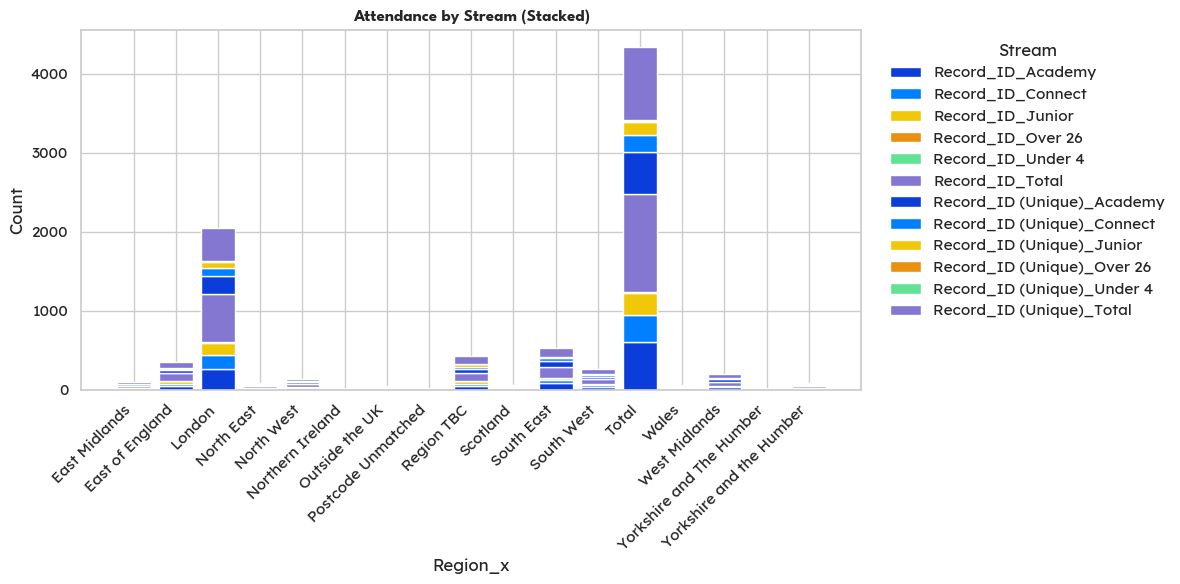

In [78]:
# --- Start from Region x Stream pivot (already flattened) ---
pivot_df = Att_v4_pivot_region.copy()   # columns like 'Record_ID_<Stream>' and 'Record_ID (Unique)_<Stream>'

# Drop the 'Total' column if present so stacks sum to actual totals
if "Total" in pivot_df.columns:
    pivot_df = pivot_df.drop(columns=["Total"])

# Ensure the index column is the first col after reset_index()
index_col = pivot_df.columns[0]
value_cols = pivot_df.columns[1:]

# Sort (optional, makes bars nicer)
pivot_df = pivot_df.sort_values(by=index_col)

# Plot
plt.figure(figsize=(12, 6))
bottom = None
for i, c in enumerate(value_cols):
    plt.bar(
        pivot_df[index_col], pivot_df[c],
        bottom=bottom, label=c
    )
    bottom = pivot_df[value_cols[:i+1]].sum(axis=1)

plt.title("Attendance by Stream (Stacked)", fontname=fonts["headers"])
plt.xlabel(index_col)
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Stream", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()

## Use HeatMapping for Feedback

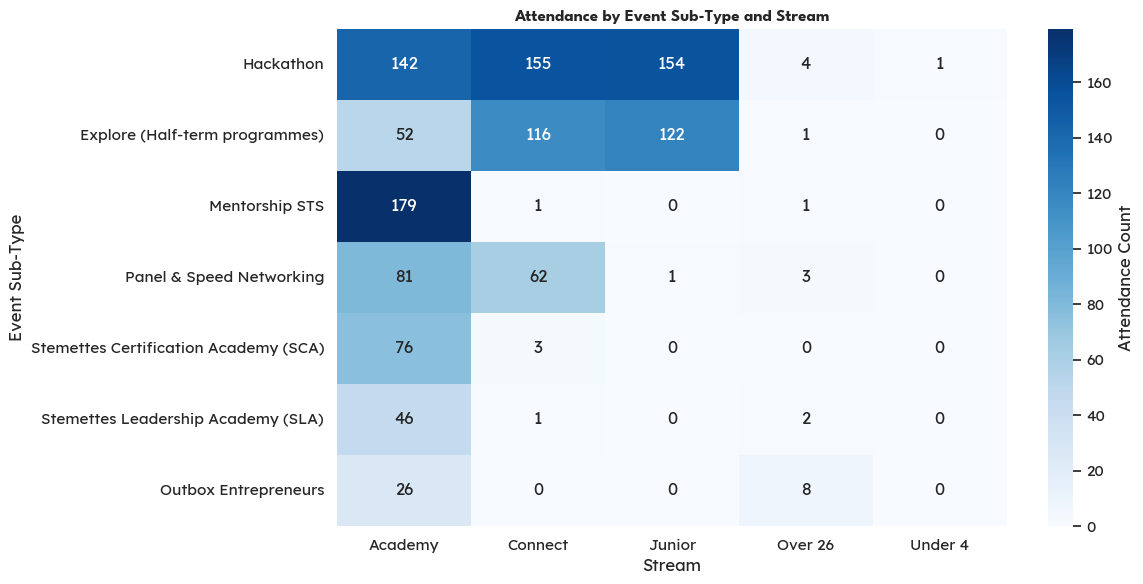

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Build a pivot table: rows = Event Sub-Type, columns = Stream
heat_df = Att_v3.pivot_table(
    index="Event Sub-Type",
    columns="Stream",
    values="Record_ID",   # or "Record_ID (Unique)" if you want unique counts
    aggfunc="count",
    fill_value=0
)

# Optional: sort rows by total count for readability
heat_df = heat_df.loc[heat_df.sum(axis=1).sort_values(ascending=False).index]

# Plot heatmap
plt.figure(figsize=(12, max(6, 0.4*len(heat_df))))  # dynamic height
sns.heatmap(
    heat_df,
    cmap="Blues",
    annot=True, fmt=".0f",   # show counts
    cbar_kws={"label": "Attendance Count"}
)

plt.title("Attendance by Event Sub-Type and Stream", fontname=fonts["headers"])
plt.xlabel("Stream")
plt.ylabel("Event Sub-Type")
plt.tight_layout()
plt.show()

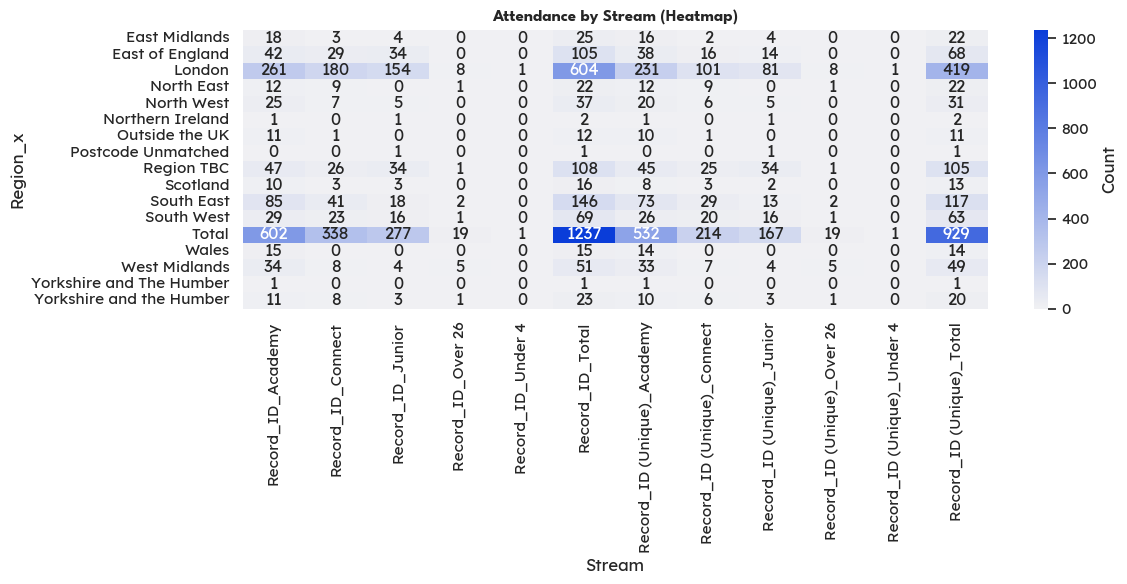

In [80]:
# Rebuild a matrix (index x stream) from the same source as the pivot
# If you already have Att_v4_pivot1/2 with a single metric and columns per Stream, use it directly:
heat_df = pivot_df.set_index(index_col)

# Drop 'Total' if present
if "Total" in heat_df.columns:
    heat_df = heat_df.drop(columns=["Total"])

plt.figure(figsize=(12, 6))
sns.heatmap(
    heat_df,
    cmap=sns.light_palette("#0a3dd9", as_cmap=True),  # gradient of brand blue
    annot=True, fmt=".0f",
    cbar_kws={"label": "Count"}
)
plt.title("Attendance by Stream (Heatmap)", fontname=fonts["headers"])
plt.xlabel("Stream")
plt.ylabel(index_col)
plt.tight_layout()
plt.show()

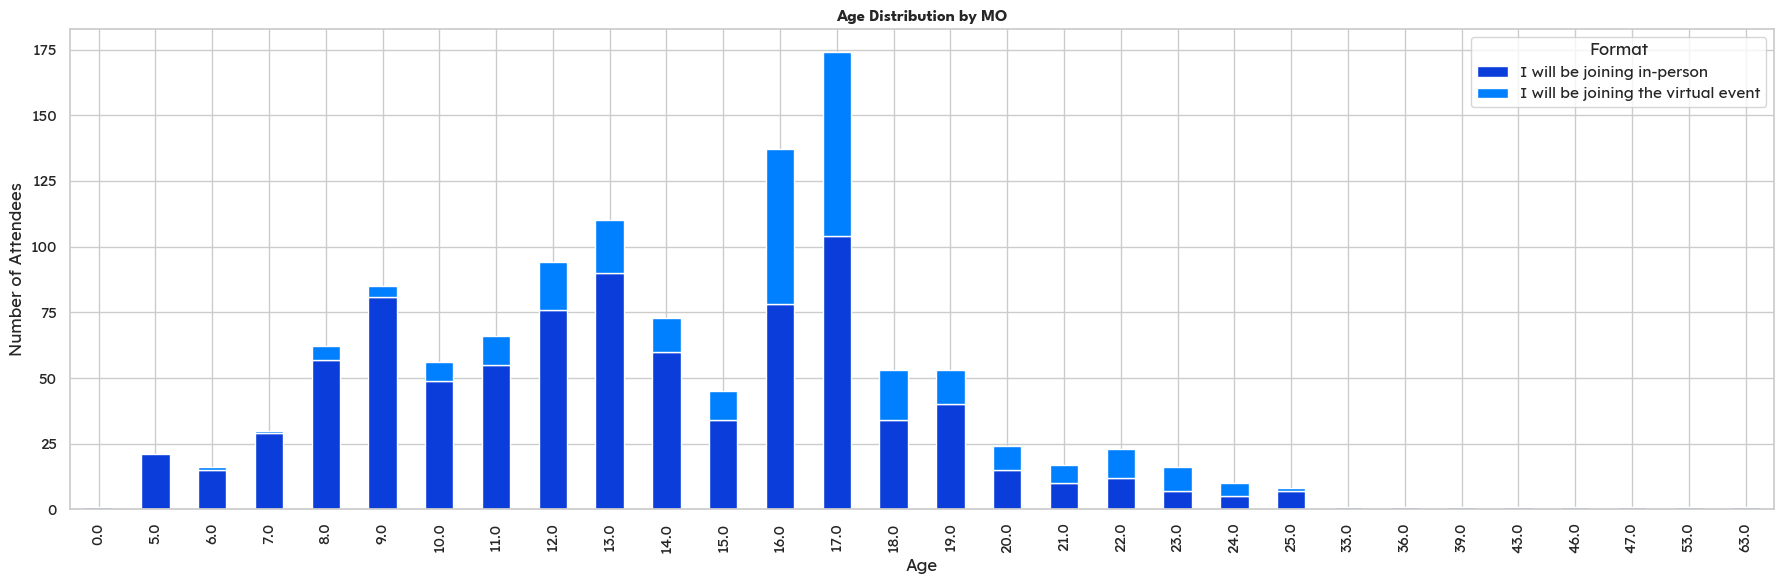

In [81]:
# Create a crosstab for stacked bars
stacked_data = pd.crosstab(Att_v3['Age on Day of'], Att_v3['Physical / Virtual'])

stacked_data.plot(kind='bar', stacked=True, figsize=(18,6))
plt.title('Age Distribution by MO',fontname=fonts['headers'])
plt.xlabel('Age')
plt.ylabel('Number of Attendees')
plt.legend(title='Format'),
plt.tight_layout()
plt.show()

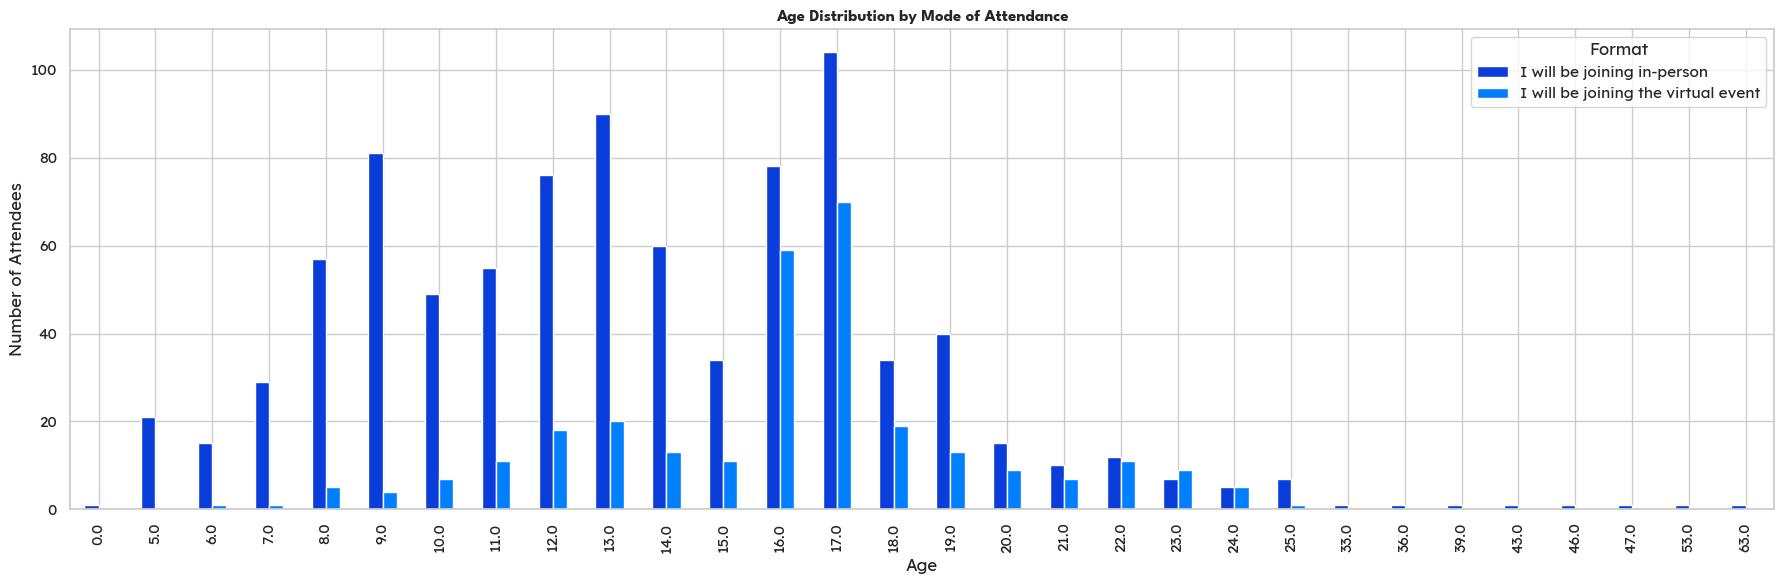

In [82]:
# Create a crosstab for adjacent (grouped) bars
grouped_data = pd.crosstab(Att_v3['Age on Day of'], Att_v3['Physical / Virtual'])

# Plot grouped bar chart (side-by-side bars)
grouped_data.plot(kind='bar', stacked=False, figsize=(18, 6))

plt.title('Age Distribution by Mode of Attendance',fontname=fonts['headers'])
plt.xlabel('Age')
plt.ylabel('Number of Attendees')
plt.legend(title='Format')
plt.tight_layout()
plt.show()

In [83]:
#Exclude anyone under 4 or over 26 (anomalies)
t1['Age on Day of'] = pd.to_numeric(t1['Age on Day of'], errors='coerce')

age_stats = t1.groupby('Event')['Age on Day of'].agg(['count','min', 'max','mean']).reset_index()
age_stats.head(11)

,Event,count,min,max,mean
0,"""Achieve, Connect, Grow: Adventures Season Panel 25""",18,12.0,20.0,15.944444
1,"""Achieve, Engineer, Explore: NewDay Hack""",38,0.0,18.0,11.578947
2,"""Achieve, Grow, Change: Pure Storage & Natilik Hack""",32,5.0,17.0,10.937500
3,"""Achieve, Listen, Meet: Ambitions Season Panel 25""",23,12.0,25.0,16.608696
4,"""Ask, Celebrate, Meet: Ambitions Season Panel 24""",12,12.0,20.0,16.416667
5,"""Create, Experiment, Solve - Insight Bristol """,30,5.0,18.0,11.466667
6,"""Create, Learn, Try Out: Connected Places Catapult and Birmingham City University in Birmingham """,27,5.0,24.0,13.148148
7,"""Discover, Listen, Meet: Insights Season Panel""",15,12.0,20.0,14.800000
8,"""Dream, Create, Solve: IWC Hack """,36,6.0,46.0,13.750000
9,"""Dream, Listen, Connect: Visions Season Panel 24""",19,11.0,36.0,15.631579


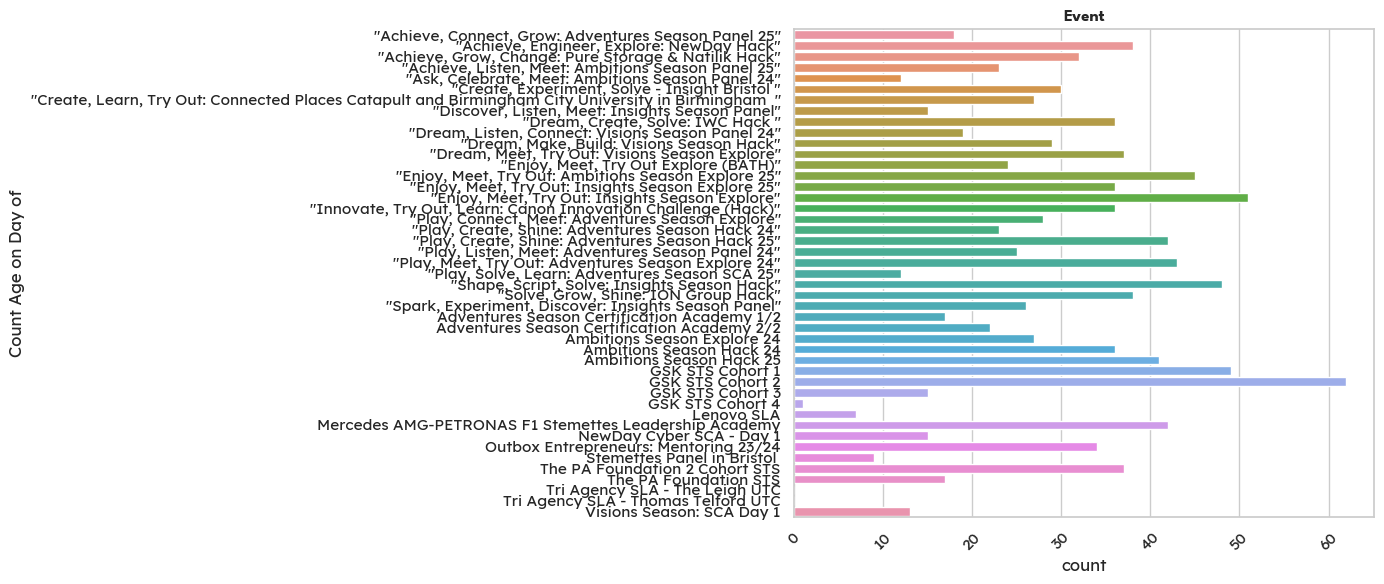

In [84]:
plt.figure(figsize=(14, 6))
sns.barplot(data=age_stats, y='Event', x='count')
plt.xticks(rotation=45)
plt.ylabel('Count Age on Day of')
plt.title('Event', fontname=fonts['headers'])
plt.tight_layout()
plt.show()

### **...Continue with more visualisations for dashboard, including pie charts, histograms, box plots and a time-series analysis scatter/line graph/plot?**

In [85]:
#Data Wrangling
#Clean up missing values
#df['date'] = pd.to_datetime(df['date']) #Convert to datetime format
#df['month'] = df['date'].dt.month #Derive month/quarter from timestamp

In [86]:
#grouped = df.groupby('age_stream')['rating_score'].mean() #Group by Age Stream

#This produces side-by-side bars for each intervention within age streams.
#grouped = df.groupby(["age_stream", "intervention_type"])["rating_score"].mean().unstack()
#grouped.plot(kind="bar", figsize=(10, 6))
#plt.ylabel("Average Rating")
#plt.title("Avg Rating by Age Stream and Intervention Type")

#Average rating per age stream: df.groupby('age_stream')['rating'].mean()
#Count of feedback by age stream
#Boxplot of rating distribution by stream

In [87]:
#Compare Trends Over Time
#df.set_index('date', inplace=True)
#monthly_avg = df.resample('M')['rating_score'].mean() #Use .resample('M') on datetime index for monthly trends
#Line plot showing monthly average rating by age stream

#You can filter for mentorships, panels, etc., and plot their average monthly rating:
#mentorship = df[df["intervention_type"] == "Mentorship"]
#monthly_avg = mentorship.resample("M")["rating_score"].mean()

#monthly_avg.plot(title="Monthly Avg Rating - Mentorship Programme")

In [88]:
#Create a grid of charts — each subplot shows rating distribution for a different intervention
#g = sns.FacetGrid(df, col="intervention_type", col_wrap=3)
#g.map(sns.histplot, "rating_score")
#You can also facet by age_stream and intervention for layered insights.

In [89]:
#Correlation Analysis
#Correlation heatmap for numeric variables
#Explore relationship between confidence_gain and rating_score

In [90]:
#Visualisations

#sns.boxplot(x='age_stream', y='rating_score', data=df)
#plt.title("Rating Distribution by Age Stream")

#sns.boxplot(x="intervention_type", y="rating_score", data=df)
#plt.xticks(rotation=45)

#Use sns.catplot() to show ratings across age streams
#Use sns.violinplot() or boxplot() to show spread of feedback

#Use sns.lineplot() with smoothing to show trends
#df['rating_smooth'] = df['rating_score'].rolling(window=3).mean() #Smoothing
#Add annotations for standout months/events

We wanted to explore how participants of different age groups respond to various intervention types. We compared confidence gains and feedback ratings across structured programmes like mentorship and SLA, versus public-facing events like panels and hacks. Using time series and multi-dimensional plots, we identified that primary-age participants responded more positively to creative workshops, while older groups preferred mentorship and panel-style events.

In [91]:
#Visualise Experience /10 scores per person
#sns.stripplot(x='Record_ID (Unique)', y='Experience /10', data=fb_renamed, jitter=True)
#plt.show()